In [471]:
# import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import math
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
from scipy.stats import betabinom
import loompy as lp
from tqdm.notebook import tqdm
from collections import defaultdict

In [472]:
import gurobipy as gp

# AML Morita et al. Data Analysis

/n/fs/ragr-data/users/aj7381/AML99/AML-99-001.loom
chr21:36193871:T/C 4392
chr21:36252877:C/T 3662
chr21:36421036:T/C 4384


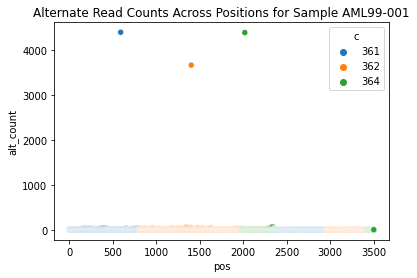

/n/fs/ragr-data/users/aj7381/AML99/AML-99-002.loom
chr21:36193871:T/C 3071
chr21:36252877:C/T 2821
chr21:36421036:T/C 3044


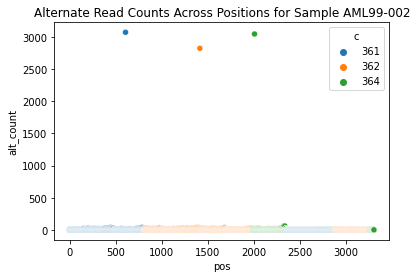

/n/fs/ragr-data/users/aj7381/AML99/AML-99-003.loom
chr21:36193871:T/C 4275
chr21:36252877:C/T 3437
chr21:36421036:T/C 4281


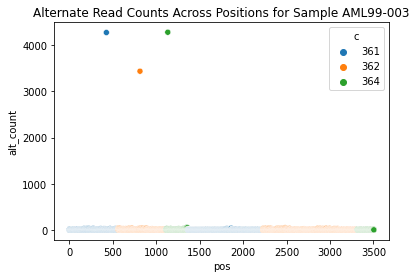

/n/fs/ragr-data/users/aj7381/AML99/AML-99-004.loom
chr21:36193871:T/C 3446
chr21:36252877:C/T 1353
chr21:36421036:T/C 3444


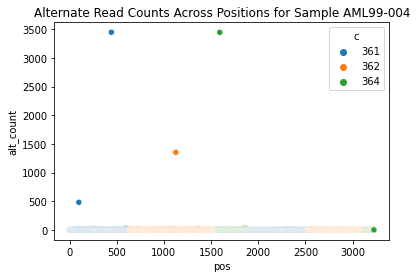

/n/fs/ragr-data/users/aj7381/AML99/AML-99-005.loom
chr21:36193871:T/C 3973
chr21:36252877:C/T 2483
chr21:36421036:T/C 3967


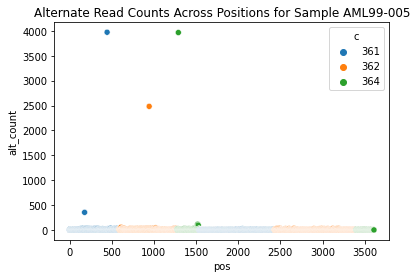

In [181]:
for sample in list(range(1,6)):
    ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/AML99/AML-99-00{sample}.loom')
    RUNX1_alt_counts = []
    colors = []
    print(f'/n/fs/ragr-data/users/aj7381/AML99/AML-99-00{sample}.loom')
    for i in range(len(ds.ra.amplicon)):
        
        if 'RUNX1' in str(ds.ra.amplicon[i]):
            pos = int(str(ds.ra.id[i]).split(':')[1])
            loc = pos // 100000
            colors.append(f'{loc}')
           
            unique_entries = np.unique(ds[i,:], return_counts=True)
            alt_count = 0
            if 1 in unique_entries[0]:
                idx1 = np.where(unique_entries[0] == 1)[0][0]
                alt_count += unique_entries[1][idx1]

            if 2 in unique_entries[0]:
                idx2 = np.where(unique_entries[0] == 2)[0][0]
                alt_count += unique_entries[1][idx2]

            if alt_count > 500:
                print(str(ds.ra.id[i]), alt_count)

            RUNX1_alt_counts.append(alt_count)
    data = pd.DataFrame.from_dict({'pos': list(range(len(RUNX1_alt_counts))), 'alt_count': RUNX1_alt_counts, 'c': colors})
    
    sns.scatterplot(data=data, x='pos', y='alt_count', hue='c')
    plt.title(f'Alternate Read Counts Across Positions for Sample AML99-00{sample}')
    plt.show()

In [182]:
mutations_of_interest = ['RUNX1', 'IDH1', 'IDH2', 'SRSF2', 'NRAS', 'PTPN11', 'CSF3R', 'FLT3', 'DNMT3A']

In [5]:
filtered_ids = {1:set(), 2:set(), 3: set(), 4:set(), 5:set()}
for sample in list(range(1,6)):
    ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/AML99/AML-99-00{sample}.loom')
    print(len(ds.ra.amplicon))
    for i in range(len(ds.ra.amplicon)):
        for mut in mutations_of_interest:
            if mut in str(ds.ra.amplicon[i]):
                vaf = ds['AD'][i,:]/ds['DP'][i,:]
                
                if np.sum(vaf >= 0.10) > 0.10 * ds['AD'].shape[1]:
                    filtered_ids[sample].add(ds.ra.id[i])
                            
filtered_ids

110493


/tmp/ipykernel_3343483/3679452621.py:8: RuntimeWarning: invalid value encountered in divide
  vaf = ds['AD'][i,:]/ds['DP'][i,:]


105047
108364
103784
113124


In [7]:
setlist = []
for sample in list(range(1,6)):
    ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/AML99/AML-99-00{sample}.loom')

    setlist.append(set(ds.ra.id))


u = set.intersection(*setlist)
u_prime = set.union(*setlist)

print(len(u))
print(len(u_prime))
x=[]
for i in list(filtered_ids.values()):
    x.extend(i)

common_valid_mutations = list(set.intersection(u, set(x)))


64757
164169


In [8]:
RUNX1_ps = []
for m in u:
    for m1 in ['chr21:36171613']:
        if m1 in m:
            RUNX1_ps.append(m)

In [9]:
ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/AML99/AML-99-001.loom')
common_valid_mutations = RUNX1_ps
common_valid_mutations = sorted(common_valid_mutations)
genes = []
for m in common_valid_mutations:
    genes.append(ds.ra.amplicon[np.where(ds.ra.id == m)[0]][0].split('_')[1])
    if 'FLT3' in genes[-1]:
        print(ds.ra.amplicon[np.where(ds.ra.id == m)[0]][0])
    

sample 1 cells containing mutation with vaf >= 0.05


/tmp/ipykernel_3343483/3870156778.py:11: RuntimeWarning: invalid value encountered in divide
  vaf = ds['AD'][i,:]/ds['DP'][i,:]


chr21:36171613:A/AGG 63
chr21:36171613:A/G 107
sample 2 cells containing mutation with vaf >= 0.05
chr21:36171613:A/AGG 50
chr21:36171613:A/G 48
sample 3 cells containing mutation with vaf >= 0.05
chr21:36171613:A/AGG 68
chr21:36171613:A/G 115
sample 4 cells containing mutation with vaf >= 0.05
chr21:36171613:A/AGG 530
chr21:36171613:A/G 75
sample 5 cells containing mutation with vaf >= 0.05
chr21:36171613:A/AGG 453
chr21:36171613:A/G 134


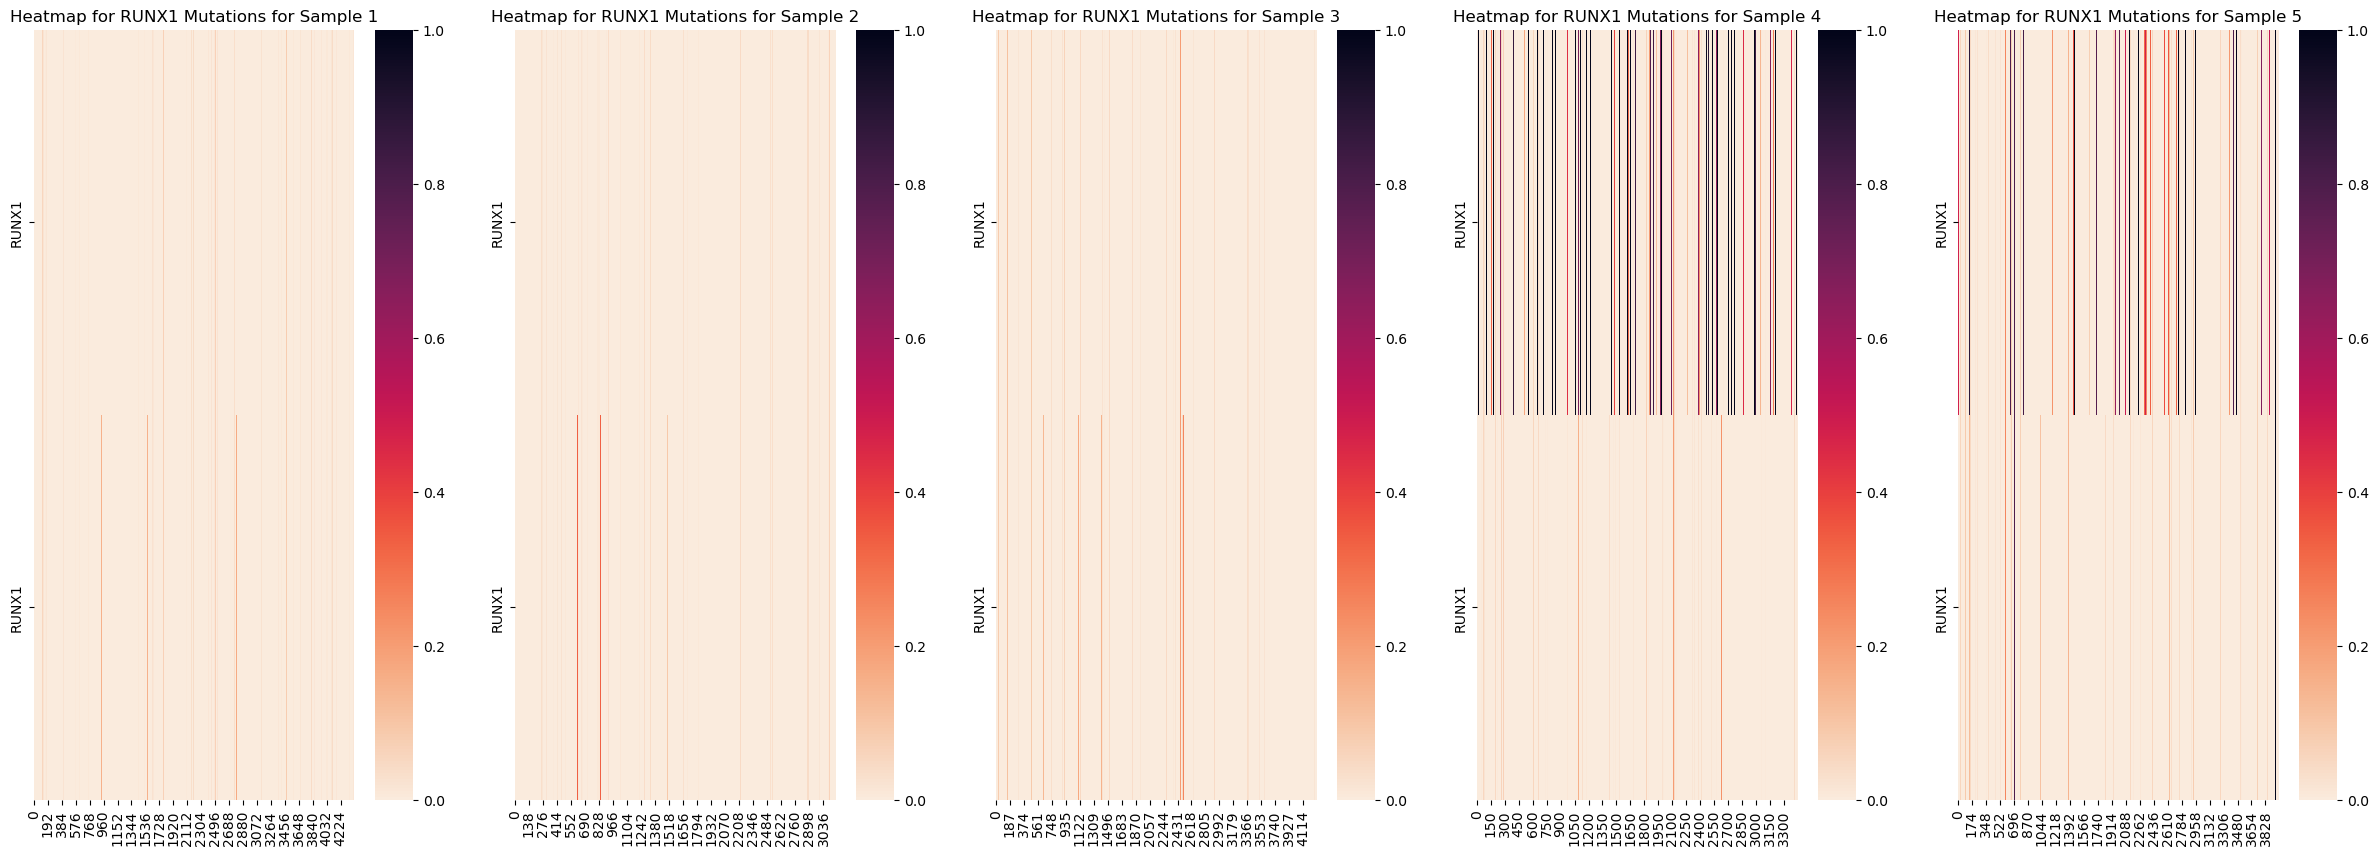

In [10]:
#mut_labels = [i.split(':')[0] + ':' + i.split(':')[1] for i in common_valid_mutations]
fig, axes = plt.subplots(1, 5, figsize=(30, 10))  # Adjust figsize as needed

for sample in list(range(1,6)):
    ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/AML99/AML-99-00{sample}.loom')

    RUNX1_vafs = np.zeros((len(common_valid_mutations), ds['AD'].shape[1]))
    print(f'sample {sample} cells containing mutation with vaf >= 0.05')
    for i in range(len(ds.ra.amplicon)):
        if ds.ra.id[i] in common_valid_mutations:
            vaf = ds['AD'][i,:]/ds['DP'][i,:]
            RUNX1_vafs[common_valid_mutations.index(ds.ra.id[i])] = vaf
            print(ds.ra.id[i], sum(vaf >= 0.05))

    np.nan_to_num(RUNX1_vafs, copy=False,nan=0)
    sns.heatmap(RUNX1_vafs, ax=axes[sample-1], yticklabels=genes, cmap = sns.color_palette("rocket_r", as_cmap=True))
    axes[sample-1].set_title(f'Heatmap for RUNX1 Mutations for Sample {sample}')

plt.show()
            

# Preprocess Loom Files

In [473]:
import numpy as np
import loompy
import pandas
import glob, os    
import sys
def preprocess_loom_files(patient_name, ntimepoints):
    for sample in list(range(1,ntimepoints + 1)):
    
        ds = loompy.connect(f'/n/fs/ragr-data/users/aj7381/panel1/{patient_name}-00{sample}.loom')
        #mutid=mut_table[mut_table.TapestriID==i].Variant.unique()
        allid=ds.ra.id
        df_merged = pandas.DataFrame()
        merged_matrix = ds.layer[""][:]
        #print(merged_matrix.shape)
        #print(np.count_nonzero(merged_matrix))
    
        genes = []
        for i in range(merged_matrix.shape[0]):
            if len(str(ds.ra.amplicon[i]).split('_')) > 1:
                genes.append(str(ds.ra.amplicon[i]).split('_')[1])
            else:
                genes.append(str(ds.ra.amplicon[i]))
        
        special_gene_idxs = [i for i in range(merged_matrix.shape[0]) if genes[i] in ["SRSF2", "RUNX1" , "GATA2"]]
        normal_gene_idxs = [i for i in range(merged_matrix.shape[0]) if genes[i] not in ["SRSF2", "RUNX1" , "GATA2"]]
        
        genotype_layer = ds.layer[""][special_gene_idxs,:]
        ad_layer = ds.layer["AD"][special_gene_idxs,:]
        dp_layer = ds.layer["DP"][special_gene_idxs,:]
    
        raw_vafs = ad_layer/dp_layer
        raw_vafs[(raw_vafs >= 0.10) & (dp_layer > 5)] = 1
        raw_vafs[(raw_vafs < 0.10) & (dp_layer > 5)] = 0
        #raw_vafs[genotype_layer > 2] = 3
        raw_vafs[dp_layer < 5] = 3

        merged_matrix[special_gene_idxs,:] = raw_vafs
        
        genotype_layer = ds.layer[""][normal_gene_idxs,:]
        ad_layer = ds.layer["AD"][normal_gene_idxs,:]
        dp_layer = ds.layer["DP"][normal_gene_idxs,:]

        
        raw_vafs = ad_layer/dp_layer
        raw_vafs[(raw_vafs >= 0.10) & (dp_layer > 5)] = 1
        raw_vafs[(raw_vafs < 0.10) & (dp_layer > 5)] = 0
        raw_vafs[dp_layer < 5] = 3
        merged_matrix[normal_gene_idxs,:] = raw_vafs

        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.allvariants.genotype_modified.txt"

        df_merged = pandas.DataFrame(merged_matrix)
        df_merged.index = allid
        print(df_merged.shape)
        df_merged.to_csv(outname, sep="\t", header=False)

        ds.close()
    

In [474]:
import numpy as np
import loompy
import pandas
import glob, os    
import sys
def preprocess_loom_files_ML_LSR(patient_name, ntimepoints):
    for sample in list(range(1,ntimepoints + 1)):
    
        ds = loompy.connect(f'/n/fs/ragr-data/users/aj7381/panel1/{patient_name}-00{sample}.loom')
        #mutid=mut_table[mut_table.TapestriID==i].Variant.unique()
        allid=ds.ra.id
        df_merged = pandas.DataFrame()
        merged_matrix = ds.layer[""][:]
        print(merged_matrix.shape)
        print(np.count_nonzero(merged_matrix))
    
        genes = []
        for i in range(merged_matrix.shape[0]):
            if len(str(ds.ra.amplicon[i]).split('_')) > 1:
                genes.append(str(ds.ra.amplicon[i]).split('_')[1])
            else:
                genes.append(str(ds.ra.amplicon[i]))
        
        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.variant_readcounts.csv"
        df_merged = pandas.DataFrame(ds.layer["AD"][:])
        df_merged.index = allid
        df_merged.to_csv(outname, sep="\t", header=False)

        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.total_readcounts.csv"
        df_merged = pandas.DataFrame(ds.layer["DP"][:])
        df_merged.index = allid
        df_merged.to_csv(outname, sep="\t", header=False)
        print(df_merged)
        ds.close()
    

## AML-63

In [829]:
preprocess_loom_files_ML_LSR('AML-66', 3)
preprocess_loom_files('AML-66', 3)

(16888, 7265)
8995740
                    0     1     2     3     4     5     6     7     8     \
chr1:115256326:A/G   135   154   236    60   156   119    47    45    50   
chr1:115256326:A/T   135   154   236    60   156   119    47    45    50   
chr1:115256333:C/A   135   154   234    60   156   117    49    45    50   
chr1:115256333:C/T   135   154   234    60   156   117    49    45    50   
chr1:115256339:T/A   135   154   234    60   154   113    49    45    46   
...                  ...   ...   ...   ...   ...   ...   ...   ...   ...   
chr21:44524496:A/T    16    27    88    18    47    36     8    18    15   
chr21:44524499:A/C    16    27    88    18    47    36     8    18    15   
chr21:44524499:A/G    16    27    88    18    47    36     8    18    15   
chr21:44524501:G/A    16    27    88    18    47    36     8    18    15   
chr21:44524501:G/T    16    27    88    18    47    36     8    18    15   

                    9     ...  7255  7256  7257  7258  7259  7260

/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


(16888, 7265)
(16937, 5641)
(14966, 1059)


## AML-97

In [772]:
preprocess_loom_files_ML_LSR('AML-97', 6)
preprocess_loom_files('AML-97', 6)

(16921, 6013)
5563373
                        0     1     2     3     4     5     6     7     8     \
chr1:115256330:G/A        70   151    65   169   105   138    59   100   119   
chr1:115256330:G/T        70   151    65   169   105   138    59   100   119   
chr1:115256342:C/G        70   155    67   165    97   140    55   102   123   
chr1:115256342:C/T        70   155    67   165    97   140    55   102   123   
chr1:115256351:T/C        70   161    73   167   105   148    61   102   127   
...                      ...   ...   ...   ...   ...   ...   ...   ...   ...   
chr21:44524501:GAACA/G    28    43    29    34    38    35    65    41    25   
chr21:44524503:A/G        28    43    29    34    38    40    65    41    25   
chr21:44524503:A/T        28    43    29    34    38    40    65    41    25   
chr21:44524504:C/T        28    43    29    34    38    40    65    41    25   
chr21:44524504:CA/C       28    43    29    34    38    40    65    41    25   

                 

(16180, 3820)
2332028
                    0     1     2     3     4     5     6     7     8     \
chr1:115256329:A/G   374   318   249   147   232   677   125   215   302   
chr1:115256329:A/T   374   318   249   147   232   677   125   215   302   
chr1:115256336:T/A   374   311   235   149   234   673   123   209   304   
chr1:115256336:T/C   374   311   235   149   234   673   123   209   304   
chr1:115256340:C/G   358   309   239   143   230   667   123   211   304   
...                  ...   ...   ...   ...   ...   ...   ...   ...   ...   
chr21:44524500:T/C   110   129    54    77    73   201    18    34    93   
chr21:44524501:G/A   110   129    54    77    73   201    18    34    93   
chr21:44524501:G/T   110   129    54    77    73   201    18    34    93   
chr21:44524502:A/G   110   129    54    77    73   201    18    34    93   
chr21:44524502:A/T   110   129    54    77    73   201    18    34    93   

                    9     ...  3810  3811  3812  3813  3814  3815

/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


(16921, 6013)
(13053, 742)
(16779, 3482)
(15997, 2089)
(16180, 3820)
(16821, 3186)


## AML-63

In [475]:
preprocess_loom_files_ML_LSR('AML-63', 5)
preprocess_loom_files('AML-63', 5)

(3808, 8347)
1908859
                         0     1     2     3     4     5     6     7     8     \
NRAS_1:1:115256326:A/G     80    86    58    32   118    64    98    95    56   
NRAS_1:1:115256327:A/G     80    86    58    32   118    64    98    95    56   
NRAS_1:1:115256328:A/G     80    86    58    32   118    64    98    95    56   
NRAS_1:1:115256329:A/G     80    86    56    32   118    64    98    95    56   
NRAS_1:1:115256330:G/A     80    86    58    32   118    64    98    95    56   
...                       ...   ...   ...   ...   ...   ...   ...   ...   ...   
U2AF1_2:21:44524499:A/G    34    54    33    11    77    25    43    29    33   
U2AF1_2:21:44524502:A/G    34    54    33    11    77    23    43    29    33   
U2AF1_2:21:44524503:A/G    34    54    33    11    77    23    39    29    31   
U2AF1_2:21:44524504:C/T    34    54    33    11    77    23    43    29    33   
U2AF1_2:21:44524505:A/C    34    44    33    11    77    23    39    29    30   

      

(3763, 4618)
2524034
                    0     1     2     3     4     5     6     7     8     \
chr1:115256528:T/A    42    79    38    55    62    79    48    41    79   
chr1:115256528:T/C    42    79    38    55    62    79    48    41    79   
chr1:115256529:T/A    42    79    38    55    62    79    48    41    79   
chr1:115256529:T/C    42    79    38    55    62    79    48    41    79   
chr1:115256531:T/C    42    79    38    55    62    79    48    41    79   
...                  ...   ...   ...   ...   ...   ...   ...   ...   ...   
chr21:44514777:T/C   118   138   125   109    98   164   197    78   182   
chr21:44524453:C/A    50    59    62    58    45    85    98    45    80   
chr21:44524453:C/T    50    59    62    58    45    85    98    45    80   
chr21:44524456:G/A    50    59    62    58    45    85    98    45    80   
chr21:44524456:G/T    50    59    62    58    45    85    98    45    80   

                    9     ...  4608  4609  4610  4611  4612  4613 

/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


(3808, 8347)
(15694, 3168)
(16858, 4203)
(15786, 5421)
(3763, 4618)


# Mutation Preprocessing

In [476]:
def select_mutation(patient_name, ntimepoints):
    common_mutations = []
    for sample in list(range(1,ntimepoints + 1)):
        ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/panel1/{patient_name}-00{sample}.loom')
        if sample == 1 and patient_name == 'AML-63':
            common_mutations.append(set(['chr' + ':'.join(i.split(':')[1:]) for i in ds.ra.id]))
        else:
            common_mutations.append(set(ds.ra.id))

    for i in range(len(common_mutations)):
        if 'chr5:170837543:C/CTCTG' in common_mutations[i]:
            print('NPM1', i)
    for i in range(len(common_mutations)):
        if 'chr1:115258744:C/T' in common_mutations[i]:
            print('NRAS', i)
    common_mutations = list(set.intersection(*common_mutations))
    print(common_mutations[0])
    if 'chr5:170837543:C/CTCTG' in common_mutations:
        print('NPM1 found')

    
    print('common_mutations', len(common_mutations))

    mutations_of_interest = []
    mutations_of_interest_neg = []

    for sample in list(range(1,ntimepoints + 1)):
        ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/panel1/{patient_name}-00{sample}.loom')
        if sample == 1 and patient_name == 'AML-63':
            converted_mutations = ['chr' + ':'.join(i.split(':')[1:]) for i in ds.ra.id]
            result = [i for i in range(len(ds.ra.id)) if any(substring in converted_mutations[i] for substring in common_mutations)]

        else:
            result = [i for i in range(len(ds.ra.id)) if any(substring in ds.ra.id[i] for substring in common_mutations)]
        vafs = ds['AD'][result,:]/ds['DP'][result,:]
        print(vafs.shape)
        np.nan_to_num(vafs, copy=False,nan=0)
        #print(np.sum((vafs >= 0.8), axis=1))
        row_indices = np.where(np.sum((vafs >= 0.35), axis=1) >= 0.4*ds.shape[1])[0]

        row_indices_neg = np.where(np.sum((vafs >= 0.35), axis=1) <= 0.5*ds.shape[1])[0]


        if sample == 1 and patient_name == 'AML-63':
            mutations_of_interest.append(set([converted_mutations[result[i]] for i in row_indices]))
        else:
            mutations_of_interest.append(set([ds.ra.id[result[i]] for i in row_indices]))

        if sample == 1 and patient_name == 'AML-63':
            mutations_of_interest_neg.append(set([converted_mutations[result[i]] for i in row_indices_neg]))
        else:
            mutations_of_interest_neg.append(set([ds.ra.id[result[i]] for i in row_indices_neg]))
        
    mutations_of_interest = set.union(*mutations_of_interest)
    mutations_of_interest_neg = set.union(*mutations_of_interest_neg)
    mutations_of_interest = set.intersection(*[mutations_of_interest, mutations_of_interest_neg])
    
    annotations = {i:"_".join(i.split(':')) for i in mutations_of_interest}
    print(len(mutations_of_interest))
    print()
    print()

    #mutations_of_interest = ['chr5:170837543:C/CTCTG', 'chr1:115258744:C/T', 'chr2:25457242:C/T']
    #annotations = {'chr5:170837543:C/CTCTG': 'NPM1 p.L287fs', 'chr1:115258744:C/T': 'NRAS p.G13D', 'chr2:25457242:C/T': 'DNMT3A p.R882H'}
    
    return mutations_of_interest, annotations

        

## AML-66

In [831]:
mutations66 = select_mutation('AML-66', 3)
mutations66

NRAS 0
NRAS 1
NRAS 2
chr21:36171704:G/A
common_mutations 11076


/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


(11076, 7265)
(11076, 5641)
(11076, 1059)
6




({'chr12:112926888:G/A',
  'chr16:8569820:G/A',
  'chr16:8569820:G/T',
  'chr16:8569821:C/*',
  'chr17:7577180:C/T',
  'chr21:36171638:G/A'},
 {'chr21:36171638:G/A': 'chr21_36171638_G/A',
  'chr16:8569820:G/A': 'chr16_8569820_G/A',
  'chr17:7577180:C/T': 'chr17_7577180_C/T',
  'chr16:8569820:G/T': 'chr16_8569820_G/T',
  'chr12:112926888:G/A': 'chr12_112926888_G/A',
  'chr16:8569821:C/*': 'chr16_8569821_C/*'})

## AML-97

In [773]:
mutations97 = select_mutation('AML-97', 6)
mutations97

NPM1 0
NPM1 1
NPM1 2
NPM1 5
NRAS 0
NRAS 1
NRAS 2
NRAS 3
NRAS 4
NRAS 5
chr2:198267210:T/C
common_mutations 7091


/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


(7091, 6013)
(7091, 742)
(7091, 3482)
(7091, 2089)
(7091, 3820)
(7091, 3186)
8




({'chr10:106721610:G/A',
  'chr10:77210191:C/T',
  'chr11:32417945:T/C',
  'chr16:55770629:C/T',
  'chr1:115258744:C/T',
  'chr2:25457242:C/T',
  'chr5:170837515:T/C',
  'chr5:170837544:T/C'},
 {'chr10:106721610:G/A': 'chr10_106721610_G/A',
  'chr5:170837544:T/C': 'chr5_170837544_T/C',
  'chr5:170837515:T/C': 'chr5_170837515_T/C',
  'chr16:55770629:C/T': 'chr16_55770629_C/T',
  'chr10:77210191:C/T': 'chr10_77210191_C/T',
  'chr1:115258744:C/T': 'chr1_115258744_C/T',
  'chr2:25457242:C/T': 'chr2_25457242_C/T',
  'chr11:32417945:T/C': 'chr11_32417945_T/C'})

## AML-63

In [477]:
mutations = select_mutation('AML-63', 5)
mutations

NPM1 0
NPM1 1
NPM1 3
NPM1 4
NRAS 1
NRAS 2
NRAS 3
NRAS 4
chr11:32413561:G/A
common_mutations 531


/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


(532, 8347)
(531, 3168)
(531, 4203)
(531, 5421)
(531, 4618)
6




({'chr10:106721610:G/A',
  'chr10:77210191:C/T',
  'chr15:90631934:C/T',
  'chr16:55770629:C/T',
  'chr16:8569820:G/A',
  'chr6:17076840:C/G'},
 {'chr16:8569820:G/A': 'chr16_8569820_G/A',
  'chr10:106721610:G/A': 'chr10_106721610_G/A',
  'chr6:17076840:C/G': 'chr6_17076840_C/G',
  'chr16:55770629:C/T': 'chr16_55770629_C/T',
  'chr10:77210191:C/T': 'chr10_77210191_C/T',
  'chr15:90631934:C/T': 'chr15_90631934_C/T'})

# Produce Method Inputs

In [425]:
def produce_SCITE_input(patient_name, patient_mutations, ntimepoints):
    dfs_to_merge = []
    size = []
    for sample in list(range(1,ntimepoints+1)):
        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.allvariants.genotype_modified.txt"
        df = pd.read_csv(outname, sep='\t',header=None, index_col=0)
        if sample == 1 and patient_name == 'AML-63':
            df.index = ['chr' + ':'.join(f.split(':')[1:]) for f in df.index]

        filtered_df = df[df.index.str.contains('|'.join(patient_mutations))]
        filtered_index = filtered_df.index
        
        #if sample == 1:
            #filtered_index = ['chr' + ':'.join(f.split(':')[1:]) for f in filtered_df.index]
    
        filtered_values = filtered_df.values
        zygozity_aware_matrix = np.zeros((filtered_values.shape[0], filtered_values.shape[1]))
        
        nfiltered_index = []
        
        for r in range(filtered_values.shape[0]):
            zygozity_aware_matrix[r, :] = filtered_values[r,:]
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[2*r, :] == 2] = 0
            #zygozity_aware_matrix[2*r+1, :][zygozity_aware_matrix[2*r+1, :] == 1] = 0
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[r, :] == 2] = 1
            nfiltered_index.append(filtered_index[r] + '_1')
            #nfiltered_index.append(filtered_index[r] + '_2')
        
        df_merged = pandas.DataFrame(zygozity_aware_matrix)
        df_merged.index = nfiltered_index
        #df_merged = df_merged.loc[:, ~(df_merged == 3).any()]
        dfs_to_merge.append(df_merged)
        size.append(df_merged.shape[1])
        #print(df)
    merged_df = pd.concat(dfs_to_merge, axis=1)
    merged_df.fillna(3, inplace=True)

    merged_val = merged_df.values.astype(int)
    merged_val[merged_val < 0] = 0
    print(merged_val.shape)
    #print(np.unique(merged_val, axis=1, return_counts=True))

    np.savetxt(f'/n/fs/ragr-data/users/aj7381/{patient_name}_scite.txt', merged_val, delimiter=" ", fmt='%d')
    return merged_df, size

In [478]:
def produce_SPhyR_input(patient_name, patient_mutations, ntimepoints):
    dfs_to_merge = []
    size = []
    for sample in list(range(1,ntimepoints+1)):
        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.allvariants.genotype_modified.txt"
        df = pd.read_csv(outname, sep='\t',header=None, index_col=0)
        if sample == 1 and patient_name == 'AML-63':
            df.index = ['chr' + ':'.join(f.split(':')[1:]) for f in df.index]

        filtered_df = df[df.index.str.contains('|'.join(patient_mutations))]
        filtered_index = filtered_df.index
        
        #if sample == 1:
            #filtered_index = ['chr' + ':'.join(f.split(':')[1:]) for f in filtered_df.index]
    
        filtered_values = filtered_df.values
        zygozity_aware_matrix = np.zeros((filtered_values.shape[0], filtered_values.shape[1]))
        
        nfiltered_index = []
        
        for r in range(filtered_values.shape[0]):
            zygozity_aware_matrix[r, :] = filtered_values[r,:]
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[2*r, :] == 2] = 0
            #zygozity_aware_matrix[2*r+1, :][zygozity_aware_matrix[2*r+1, :] == 1] = 0
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[r, :] == 2] = 1
            nfiltered_index.append(filtered_index[r] + '_1')
            #nfiltered_index.append(filtered_index[r] + '_2')
        
        df_merged = pandas.DataFrame(zygozity_aware_matrix)
        df_merged.index = nfiltered_index
        #df_merged = df_merged.loc[:, ~(df_merged == 3).any()]
        dfs_to_merge.append(df_merged)
        size.append(df_merged.shape[1])
        #print(df)
    merged_df = pd.concat(dfs_to_merge, axis=1)
    merged_df.fillna(-1, inplace=True)
    merged_df.replace(3.0, -1, inplace=True)


    merged_val = merged_df.values.astype(int)
    print(merged_val.shape)
    merged_val = merged_val.T
    #print(np.unique(merged_val, axis=1, return_counts=True))
    plt.figure()
    sns.heatmap(merged_val, vmin=-1, vmax=3, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()
    f = open(f'/n/fs/ragr-data/users/aj7381/{patient_name}_sphyr.csv', "w")
    f.write(f'{merged_val.shape[0]}\n')
    f.write(f'{merged_val.shape[1]}\n')
    for r in range(merged_val.shape[0]):
        f.write(" ".join(map(str,merged_val[r].flatten())))
        f.write("\n")

    return merged_df, size

In [503]:
def produce_COMPASS_input(patient_name, patient_mutations, ntimepoints):
    
    dfs_to_merge = []
    size = []
    for sample in list(range(1,ntimepoints+1)):
        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.variant_readcounts.csv"
        df = pd.read_csv(outname, sep='\t',header=None, index_col=0)
        if sample == 1 and patient_name == 'AML-63':
            df.index = ['chr' + ':'.join(f.split(':')[1:]) for f in df.index]

        filtered_df = df[df.index.str.contains('|'.join(patient_mutations))]
        filtered_index = filtered_df.index
        
        #if sample == 1:
            #filtered_index = ['chr' + ':'.join(f.split(':')[1:]) for f in filtered_df.index]
    
        filtered_values = filtered_df.values
        zygozity_aware_matrix = np.zeros((filtered_values.shape[0], filtered_values.shape[1]))
    
        nfiltered_index = []
        
        for r in range(filtered_values.shape[0]):
            zygozity_aware_matrix[r, :] = filtered_values[r,:]
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[2*r, :] == 2] = 0
            #zygozity_aware_matrix[2*r+1, :][zygozity_aware_matrix[2*r+1, :] == 1] = 0
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[r, :] == 2] = 1
            nfiltered_index.append(filtered_index[r] + '_1')
            #nfiltered_index.append(filtered_index[r] + '_2')
        
        df_merged = pandas.DataFrame(zygozity_aware_matrix)
        df_merged.index = nfiltered_index
        #df_merged = df_merged.loc[:, ~(df_merged == 3).any()]
        dfs_to_merge.append(df_merged)
        size.append(df_merged.shape[1])
        #print(df)
    merged_df_var = pd.concat(dfs_to_merge, axis=1).transpose()   # Initialize with the first DataFrame
    merged_df_var.fillna(-1, inplace=True)
    merged_df_var.index = range(len(merged_df_var))

    #merged_df.to_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_variant_readcounts.csv')    

    dfs_to_merge = []
    size = []
    for sample in list(range(1,ntimepoints+1)):
        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.total_readcounts.csv"
        df = pd.read_csv(outname, sep='\t',header=None, index_col=0)
        if sample == 1 and patient_name == 'AML-63':
            df.index = ['chr' + ':'.join(f.split(':')[1:]) for f in df.index]

        filtered_df = df[df.index.str.contains('|'.join(patient_mutations))]
        filtered_index = filtered_df.index
        
        #if sample == 1:
            #filtered_index = ['chr' + ':'.join(f.split(':')[1:]) for f in filtered_df.index]
    
        filtered_values = filtered_df.values
        zygozity_aware_matrix = np.zeros((filtered_values.shape[0], filtered_values.shape[1]))
    
        nfiltered_index = []
        
        for r in range(filtered_values.shape[0]):
            zygozity_aware_matrix[r, :] = filtered_values[r,:]
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[2*r, :] == 2] = 0
            #zygozity_aware_matrix[2*r+1, :][zygozity_aware_matrix[2*r+1, :] == 1] = 0
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[r, :] == 2] = 1
            nfiltered_index.append(filtered_index[r] + '_1')
            #nfiltered_index.append(filtered_index[r] + '_2')
        
        df_merged = pandas.DataFrame(zygozity_aware_matrix)
        df_merged.index = nfiltered_index
        #df_merged = df_merged.loc[:, ~(df_merged == 3).any()]
        dfs_to_merge.append(df_merged)
        size.append(df_merged.shape[1])
        #print(df)
    merged_df = pd.concat(dfs_to_merge, axis=1).transpose()   # Initialize with the first DataFrame
    merged_df.fillna(-1, inplace=True)
    merged_df.index = range(len(merged_df))
    #merged_df.to_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_total_readcounts.csv')    
    print(merged_df)
    
    with open(f'/n/fs/ragr-data/users/aj7381/{patient_name}_COMPASS_variants.csv', "w") as vcf:
        # Write header line
        vcf.write("CHR,REF,ALT,REGION,NAME,FREQ," + ",".join([str(i) for i in range(merged_df.shape[0])]) + "\n")            
        for i, mutation in enumerate(merged_df.columns):
            print(mutation)
            chrom = mutation.split(':')[0]
            pos = mutation
            vid = '.'

            vs = list(merged_df_var[mutation])
            ts = list(merged_df[mutation])
            ref = 'A'
            alt = 'T'
            qual = '.'
            filter_ = '.'
            info = '.'


            vcf.write(f"{chrom},{ref},{alt},{pos},{pos},0," + ",".join([f'{int(tot-var)}:{int(var)}' for var,tot in zip(vs, ts)])+"\n")


    return merged_df, size

In [504]:
def produce_ML_LSR_input(patient_name, patient_mutations, ntimepoints):
    
    dfs_to_merge = []
    size = []
    for sample in list(range(1,ntimepoints+1)):
        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.variant_readcounts.csv"
        df = pd.read_csv(outname, sep='\t',header=None, index_col=0)
        if sample == 1 and patient_name == 'AML-63':
            df.index = ['chr' + ':'.join(f.split(':')[1:]) for f in df.index]

        filtered_df = df[df.index.str.contains('|'.join(patient_mutations))]
        filtered_index = filtered_df.index
        
        #if sample == 1:
            #filtered_index = ['chr' + ':'.join(f.split(':')[1:]) for f in filtered_df.index]
    
        filtered_values = filtered_df.values
        zygozity_aware_matrix = np.zeros((filtered_values.shape[0], filtered_values.shape[1]))
    
        nfiltered_index = []
        
        for r in range(filtered_values.shape[0]):
            zygozity_aware_matrix[r, :] = filtered_values[r,:]
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[2*r, :] == 2] = 0
            #zygozity_aware_matrix[2*r+1, :][zygozity_aware_matrix[2*r+1, :] == 1] = 0
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[r, :] == 2] = 1
            nfiltered_index.append(filtered_index[r] + '_1')
            #nfiltered_index.append(filtered_index[r] + '_2')
        
        df_merged = pandas.DataFrame(zygozity_aware_matrix)
        df_merged.index = nfiltered_index
        #df_merged = df_merged.loc[:, ~(df_merged == 3).any()]
        dfs_to_merge.append(df_merged)
        size.append(df_merged.shape[1])
        #print(df)
    merged_df = pd.concat(dfs_to_merge, axis=1).transpose()   # Initialize with the first DataFrame
    merged_df.fillna(-1, inplace=True)
    merged_df.index = range(len(merged_df))

    merged_df.to_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_variant_readcounts.csv')    

    dfs_to_merge = []
    size = []
    for sample in list(range(1,ntimepoints+1)):
        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.total_readcounts.csv"
        df = pd.read_csv(outname, sep='\t',header=None, index_col=0)
        if sample == 1 and patient_name == 'AML-63':
            df.index = ['chr' + ':'.join(f.split(':')[1:]) for f in df.index]

        filtered_df = df[df.index.str.contains('|'.join(patient_mutations))]
        filtered_index = filtered_df.index
        
        #if sample == 1:
            #filtered_index = ['chr' + ':'.join(f.split(':')[1:]) for f in filtered_df.index]
    
        filtered_values = filtered_df.values
        zygozity_aware_matrix = np.zeros((filtered_values.shape[0], filtered_values.shape[1]))
    
        nfiltered_index = []
        
        for r in range(filtered_values.shape[0]):
            zygozity_aware_matrix[r, :] = filtered_values[r,:]
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[2*r, :] == 2] = 0
            #zygozity_aware_matrix[2*r+1, :][zygozity_aware_matrix[2*r+1, :] == 1] = 0
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[r, :] == 2] = 1
            nfiltered_index.append(filtered_index[r] + '_1')
            #nfiltered_index.append(filtered_index[r] + '_2')
        
        df_merged = pandas.DataFrame(zygozity_aware_matrix)
        df_merged.index = nfiltered_index
        #df_merged = df_merged.loc[:, ~(df_merged == 3).any()]
        dfs_to_merge.append(df_merged)
        size.append(df_merged.shape[1])
        #print(df)
    merged_df = pd.concat(dfs_to_merge, axis=1).transpose()   # Initialize with the first DataFrame
    merged_df.fillna(-1, inplace=True)
    merged_df.index = range(len(merged_df))
    merged_df.to_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_total_readcounts.csv')    
    print(merged_df)
    
    dfs_to_merge = []
    size = []
    for sample in list(range(1,ntimepoints+1)):
        outname = f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.allvariants.genotype_modified.txt"
        df = pd.read_csv(outname, sep='\t',header=None, index_col=0)
        if sample == 1 and patient_name == 'AML-63':
            df.index = ['chr' + ':'.join(f.split(':')[1:]) for f in df.index]

        filtered_df = df[df.index.str.contains('|'.join(patient_mutations))]
        filtered_index = filtered_df.index
        
        #if sample == 1:
            #filtered_index = ['chr' + ':'.join(f.split(':')[1:]) for f in filtered_df.index]
    
        filtered_values = filtered_df.values
        zygozity_aware_matrix = np.zeros((filtered_values.shape[0], filtered_values.shape[1]))
    
        nfiltered_index = []
        
        for r in range(filtered_values.shape[0]):
            zygozity_aware_matrix[r, :] = filtered_values[r,:]
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[2*r, :] == 2] = 0
            #zygozity_aware_matrix[2*r+1, :][zygozity_aware_matrix[2*r+1, :] == 1] = 0
            #zygozity_aware_matrix[r, :][zygozity_aware_matrix[r, :] == 2] = 1
            nfiltered_index.append(filtered_index[r] + '_1')
            #nfiltered_index.append(filtered_index[r] + '_2')
        
        df_merged = pandas.DataFrame(zygozity_aware_matrix)
        df_merged.index = nfiltered_index
        #df_merged = df_merged.loc[:, ~(df_merged == 3).any()]
        dfs_to_merge.append(df_merged)
        size.append(df_merged.shape[1])
        #print(df)
    merged_df = pd.concat(dfs_to_merge, axis=1).transpose()   # Initialize with the first DataFrame
    merged_df.fillna(-1, inplace=True)
    merged_df.replace(3.0, -1, inplace=True)
    
    merged_df.index = range(len(merged_df))    
    
    tps = []
    for i in range(ntimepoints):
        tps.extend([i]*size[i])
    merged_df['timepoint'] = tps
    
    plt.figure()
    sns.heatmap(merged_df.values, vmin=-1, vmax=7, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()

    merged_df['cluster_id'] = 0

    
    merged_df.to_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_character_matrix_with_timepoints.csv')    

    print(merged_df)
    return merged_df, size

## AML-66

       chr12:112926888:G/A_1  chr16:8569820:G/A_1  chr16:8569820:G/T_1  \
0                       33.0                 16.0                 16.0   
1                       43.0                 20.0                 20.0   
2                       50.0                  7.0                  7.0   
3                       16.0                 13.0                 13.0   
4                       50.0                 15.0                 15.0   
...                      ...                  ...                  ...   
13960                   21.0                  5.0                  5.0   
13961                  125.0                 12.0                 12.0   
13962                   68.0                 55.0                 55.0   
13963                  217.0                  2.0                  2.0   
13964                  159.0                 47.0                 47.0   

       chr16:8569821:C/*_1  chr17:7577180:C/T_1  chr21:36171638:G/A_1  
0                     16.0             

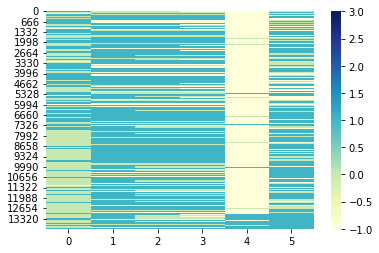

       chr12:112926888:G/A_1  chr16:8569820:G/A_1  chr16:8569820:G/T_1  \
0                       33.0                 16.0                 16.0   
1                       43.0                 20.0                 20.0   
2                       50.0                  7.0                  7.0   
3                       16.0                 13.0                 13.0   
4                       50.0                 15.0                 15.0   
...                      ...                  ...                  ...   
13960                   21.0                  5.0                  5.0   
13961                  125.0                 12.0                 12.0   
13962                   68.0                 55.0                 55.0   
13963                  217.0                  2.0                  2.0   
13964                  159.0                 47.0                 47.0   

       chr16:8569821:C/*_1  chr17:7577180:C/T_1  chr21:36171638:G/A_1  
0                     16.0             

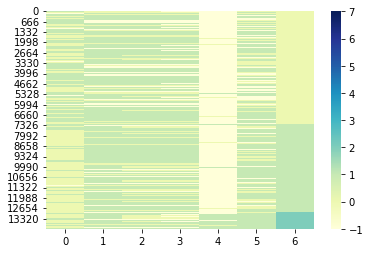

       chr12:112926888:G/A_1  chr16:8569820:G/A_1  chr16:8569820:G/T_1  \
0                        1.0                  1.0                  1.0   
1                        1.0                  1.0                  1.0   
2                        1.0                  1.0                  0.0   
3                        0.0                  1.0                  1.0   
4                        1.0                  1.0                  1.0   
...                      ...                  ...                  ...   
13960                    1.0                  0.0                  0.0   
13961                    1.0                  1.0                  0.0   
13962                    0.0                  1.0                  1.0   
13963                    0.0                 -1.0                 -1.0   
13964                    1.0                  0.0                  0.0   

       chr16:8569821:C/*_1  chr17:7577180:C/T_1  chr21:36171638:G/A_1  \
0                      1.0            

In [832]:
merged_df, size66 = produce_COMPASS_input('AML-66', list(mutations66[0]), 3)
merged_df_s, size66 = produce_SPhyR_input('AML-66', list(mutations66[0]), 3)
merged_df_ML_LPR, size66 = produce_ML_LSR_input('AML-66', list(mutations66[0]), 3)

## AML-97

       chr1:115258744:C/T_1  chr2:25457242:C/T_1  chr5:170837515:T/C_1  \
0                       6.0                  6.0                  10.0   
1                      44.0                106.0                  79.0   
2                      25.0                 21.0                  54.0   
3                      16.0                 30.0                   4.0   
4                      17.0                 18.0                  21.0   
...                     ...                  ...                   ...   
19327                  38.0                164.0                  73.0   
19328                  40.0                 54.0                  45.0   
19329                  13.0                 22.0                  81.0   
19330                  25.0                 68.0                 124.0   
19331                   9.0                 36.0                   2.0   

       chr5:170837544:T/C_1  chr10:77210191:C/T_1  chr10:106721610:G/A_1  \
0                       6.0        

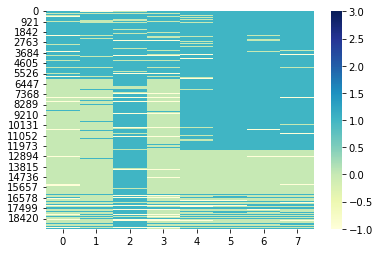

       chr1:115258744:C/T_1  chr2:25457242:C/T_1  chr5:170837515:T/C_1  \
0                       6.0                  6.0                  10.0   
1                      44.0                106.0                  79.0   
2                      25.0                 21.0                  54.0   
3                      16.0                 30.0                   4.0   
4                      17.0                 18.0                  21.0   
...                     ...                  ...                   ...   
19327                  38.0                164.0                  73.0   
19328                  40.0                 54.0                  45.0   
19329                  13.0                 22.0                  81.0   
19330                  25.0                 68.0                 124.0   
19331                   9.0                 36.0                   2.0   

       chr5:170837544:T/C_1  chr10:77210191:C/T_1  chr10:106721610:G/A_1  \
0                       6.0        

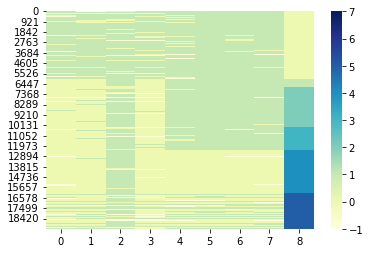

       chr1:115258744:C/T_1  chr2:25457242:C/T_1  chr5:170837515:T/C_1  \
0                       1.0                  1.0                   1.0   
1                       0.0                  0.0                   1.0   
2                       1.0                  1.0                   1.0   
3                       1.0                  1.0                  -1.0   
4                       1.0                  1.0                   1.0   
...                     ...                  ...                   ...   
19327                   0.0                  0.0                   0.0   
19328                   1.0                  1.0                   1.0   
19329                   1.0                  1.0                   1.0   
19330                   1.0                  1.0                   1.0   
19331                   0.0                  0.0                  -1.0   

       chr5:170837544:T/C_1  chr10:77210191:C/T_1  chr10:106721610:G/A_1  \
0                       1.0        

In [774]:
merged_df, size = produce_COMPASS_input('AML-97', list(mutations97[0]), 6)
merged_df_s, size = produce_SPhyR_input('AML-97', list(mutations97[0]), 6)
merged_df_ML_LPR, size = produce_ML_LSR_input('AML-97', list(mutations97[0]), 6)



## AML-63

       chr6:17076840:C/G_1  chr10:77210191:C/T_1  chr10:106721610:G/A_1  \
0                     15.0                  10.0                   36.0   
1                    121.0                  14.0                   49.0   
2                     12.0                   9.0                   25.0   
3                     37.0                   5.0                   25.0   
4                     40.0                  30.0                   41.0   
...                    ...                   ...                    ...   
25752                 29.0                  16.0                   77.0   
25753                 46.0                  23.0                   59.0   
25754                 90.0                  32.0                  111.0   
25755                115.0                  33.0                  144.0   
25756                 25.0                 112.0                   30.0   

       chr15:90631934:C/T_1  chr16:8569820:G/A_1  chr16:55770629:C/T_1  
0                      45.

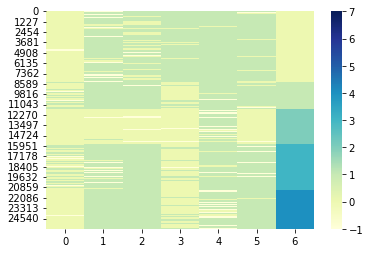

       chr6:17076840:C/G_1  chr10:77210191:C/T_1  chr10:106721610:G/A_1  \
0                      0.0                   1.0                    1.0   
1                      0.0                   1.0                    1.0   
2                      0.0                   1.0                    0.0   
3                      0.0                   0.0                    1.0   
4                      0.0                   1.0                    1.0   
...                    ...                   ...                    ...   
25752                  0.0                   1.0                    1.0   
25753                  0.0                   1.0                    1.0   
25754                  0.0                   1.0                    1.0   
25755                  0.0                   1.0                    1.0   
25756                  0.0                   1.0                    1.0   

       chr15:90631934:C/T_1  chr16:8569820:G/A_1  chr16:55770629:C/T_1  \
0                       1

In [820]:
merged_df, size = produce_COMPASS_input('AML-63', list(mutations[0]), 5)
merged_df_ML_LPR, size = produce_ML_LSR_input('AML-63', list(mutations[0]), 5)



# Run Methods

In [ ]:
import os
def run_SCITE(patient_name, nmutations, ncells, fp, fn, n_iter, n_restarts, sd):
    #os.system(['/n/fs/ragr-data/users/palash/SCITE/scite', '-i', f'{patient_name}_scite.txt', '-n', f'{nmutations}', '-m', f'{ncells}', '-o', f'/n/fs/ragr-data/users/aj7381/{patient_name}', '-a', '-cc', '0', '-r', f'{n_restarts}', '-l', f'{n_iter}', '-fd', f'{fp}', '-ad', f'{fn}', '-sd', f'{sd}', '-max_treelist_size', '1'])
    print(os.system(f'/n/fs/ragr-data/users/palash/SCITE/scite -i {patient_name}_scite.txt -n {nmutations} -m {ncells} -o /n/fs/ragr-data/users/aj7381/{patient_name} -a -cc 0 -r {n_restarts} -l {n_iter} -fd {fp} -ad {fn} -sd {sd} -max_treelist_size 1'))

In [821]:
def calculate_likelihood_rc(inferred, variant, total, prop):
        import scipy
        l = 0
        fp_error_rate = prop
        alpha = fp_error_rate * 15
        beta = (1-fp_error_rate) * 15
        for r in range(inferred.shape[0]):
            for c in range(inferred.shape[1]):
                if inferred[r,c] > 0:
                    if total[r,c] > 0:
                        l += scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], 1, 1) - scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], alpha, beta)
        return l

# Analyze Method Results

In [456]:
def analyze_SCITE_results(patient_name, patient_mutations, patient_annotations, nmutations, ntimepoints, size, ncells):
    size_progression = [sum(size[:i]) for i in range(len(size))]
    cell_attachments = {}
    anns = []
    for n in merged_df.index:
        for m in patient_mutations:
            if m in n:
                anns.append(patient_annotations[m])
    anns.append('root')
    possible_nodes = list(patient_annotations.values()) + ['root']
    for i in possible_nodes:
        cell_attachments[i] = {}
        for j in range(1,ntimepoints + 1):
            cell_attachments[i][j] = 0
    
    gv_file = open(f'/n/fs/ragr-data/users/aj7381/{patient_name}_ml0.gv', 'r')
    G = nx.DiGraph()
    for i in range(nmutations + 3):
        l = gv_file.readline()
        if i >= 2 and i < nmutations + 2:
            u = int(l.split('->')[0].strip())
            v = int(l.split('->')[1].strip()[:-1])
            if anns[u-1] not in G.nodes():
                G.add_node(anns[u-1])
            if anns[v-1] not in G.nodes():
                G.add_node(anns[v-1])
            G.add_edge(anns[u-1], anns[v-1])
            
    print(size_progression)
    l = gv_file.readline()
    taken_v = set()
    cnter = 0
    fkcnter = 0

    while(len(l) > 3):
        u = int(l.split('->')[0].strip())
        v = int(l.split('->')[1].strip()[1:-1])
        fkcnter += 1

        if v not in taken_v:
            cnter += 1
            taken_v.add(v)
            tp = len(size) - 1
            for i in range(len(size) - 1):
                if v >= size_progression[i] and v < size_progression[i+1]:  
                    tp = i
            cell_attachments[anns[u-1]][tp+1] += 1

        l = gv_file.readline()

    print(cnter)
    print(fkcnter)
    for k in cell_attachments.keys():
        G.add_node(f'{k}-t{1}')
        G.add_edge(k, f'{k}-t{1}')
        for i in range(2, len(cell_attachments[k].keys()) + 1):
            G.add_edge(f'{k}-t{i-1}', f'{k}-t{i}')
    node_sizes = []
    pos = graphviz_layout(G, prog="dot")
    node_colors = []
    for n in G.nodes():
        if len(n.split('-')) > 1:
            timepoint_frac = cell_attachments[n.split('-')[0]][int(n.split('-')[1][1:])]
            sum_ = sum([cell_attachments[k][int(n.split('-')[1][1:])] for k in cell_attachments.keys()])
            node_sizes.append(timepoint_frac * 1000 / sum_)
            node_colors.append('orange')
        else:
            node_sizes.append(100)
            node_colors.append('blue')
    
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=5, ha='center', va='center')

    for node, (x, y) in pos.items():
        if len(node.split('-')) > 1:
            plt.text(x+80, y-20, cell_attachments[node.split('-')[0]][int(node.split('-')[1][1:])], fontsize=7, ha='center', va='center')
    
    
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes)
    plt.figure(figsize=(20, 10), dpi=480)
    plt.show()

            
    
    

In [836]:
def analyze_SPhyR_results(patient_name, patient_mutations, patient_annotations, nmutations, ntimepoints, size, ncells):

    time_cells = defaultdict()
    '''
    def visualize_tree(nx_graph):
        pos = nx.nx_agraph.graphviz_layout(nx_graph, prog='dot')
        nx.draw(nx_graph, pos, with_labels=True, arrows=True)
        plt.show()
    ''' 

    df_sol = pd.read_csv(f'{patient_name}_sphyr_result.csv',sep=' ',skiprows=2, header=None)
    df_vals = df_sol.values
    
    genotype_matrix = np.unique(df_vals, axis=0)
    
    
    COMPASS_cell_assignment = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_COMPASS_results_cellAssignments.tsv', sep='\t')
    COMPASS_genotypes = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_COMPASS_results_nodes_genotypes.tsv', sep='\t')
    def build_compass_matrix(cell_assignment, genotype_file):
        mat = np.zeros((cell_assignment.shape[0], nmutations))
        profiles = genotype_file.values[:, 1:]
        for cell in range(cell_assignment.shape[0]):
            mat[cell] = profiles[cell_assignment['node'][cell]].astype(int)
        return mat
    
    COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
    tvec = []
    for i in range(1, len(size) + 1):
        tvec.extend([i]*size[i-1])
        
    cnter = 0
    for r in range(df_vals.shape[0]):
        if " ".join(map(str, map(int, df_vals[r]))) not in time_cells:
            time_cells[" ".join(map(str, map(int, df_vals[r])))] = defaultdict(int)
        time_cells[" ".join(map(str, map(int, df_vals[r])))][tvec[r]] += 1
        cnter += 1
    # Step 3: Visualize the graph as a tree
    #visualize_tree(nx_graph)
    print(cnter)
    plt.figure()
    sns.heatmap(df_vals, vmin=0, vmax=1, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()
    
    def build_mutation_tree(genotype_matrix, COMPASS_genotypes):

        anc_map = defaultdict(str)
        genotype_map = defaultdict(lambda:'root')
        genotype_map[" ".join(['0' for i in range(nmutations)])] = 'root' 

        genotype_map_r = defaultdict(str)
        genotype_map_r['root'] = " ".join(['0' for i in range(nmutations)])
        
        print(genotype_matrix)
        if patient_name == 'AML-63':
            genotype_matrix = np.vstack([genotype_matrix,[0,0,1,0,1,1]])
        elif patient_name == 'AML-97':
            genotype_matrix = np.vstack([genotype_matrix,[0,0,1,0,0,1,0,0]])
        for c in range(genotype_matrix.shape[1]):
            min_one = 10
            min_r = None
            for r in range(genotype_matrix.shape[0]):
                if genotype_matrix[r,c] == 1:
                    if sum(genotype_matrix[r]) < min_one:
                        min_one= sum(genotype_matrix[r])
                        min_r = " ".join(map(str, map(int, genotype_matrix[r])))
            genotype_map[min_r] = COMPASS_genotypes.columns[1:][c][:-2].replace(":", "_")
            genotype_map_r[COMPASS_genotypes.columns[1:][c][:-2].replace(":", "_")] = min_r

        for r in range(genotype_matrix.shape[0]):
            for r2 in range(genotype_matrix.shape[0]):
                is_subset = np.isin(genotype_matrix[r], genotype_matrix[r2]).all()
                if is_subset == True and sum(genotype_matrix[r2]) - 1 == sum(genotype_matrix[r]):
                    anc_map[genotype_map[" ".join(map(str, map(int, genotype_matrix[r2])))]] = genotype_map[" ".join(map(str, map(int, genotype_matrix[r])))]

        return anc_map, genotype_map, genotype_map_r
    
    G = nx.DiGraph()
    anc_map, genotype_map, genotype_map_r = build_mutation_tree(genotype_matrix, COMPASS_genotypes)
    
    for k,v in anc_map.items():
        if v == "root":
            G.add_node(k)
            G.add_node('root')
            G.add_edge('root', k)

        else:
            G.add_node(k)
            G.add_node(v)
            G.add_edge(v, k)

    total_backbone = list(G.nodes())
    for k in total_backbone:
        G.add_node(f'{k}-t{1}')
        G.add_edge(k, f'{k}-t{1}')
        for i in range(2, ntimepoints + 1):
            G.add_node(f'{k}-t{i}')
            G.add_edge(f'{k}-t{i-1}', f'{k}-t{i}')

    node_sizes = []
    pos = graphviz_layout(G, prog="dot")

    node_colors = []
    for n in G.nodes():
        if len(n.split('-')) > 1:
            if genotype_map_r[n.split('-')[0]] not in time_cells:
                time_cells[genotype_map_r[n.split('-')[0]]] = defaultdict(int)
                time_cells[genotype_map_r[n.split('-')[0]]][int(n.split('-')[1][1:])] = 0

            timepoint_frac = time_cells[genotype_map_r[n.split('-')[0]]][int(n.split('-')[1][1:])]
            sum_ = sum([time_cells[k][int(n.split('-')[1][1:])] for k in time_cells.keys()])
            node_sizes.append(timepoint_frac * 1000 / sum_)
            node_colors.append('orange')
        else:
            node_sizes.append(100)
            node_colors.append('blue')
    
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=5, ha='center', va='center')

    for node, (x, y) in pos.items():
        if len(node.split('-')) > 1:
            plt.text(x+80, y-20, time_cells[genotype_map_r[node.split('-')[0]]][int(node.split('-')[1][1:])], fontsize=7, ha='center', va='center')
    
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes)

    plt.show()
    
    
    
    variant_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_variant_readcounts.csv')
    total_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_total_readcounts.csv')
    

    print(calculate_likelihood_rc(df_vals, variant_df.values, total_df.values, 0.01))

In [835]:
def analyze_COMPASS_results(patient_name, patient_mutations, patient_annotations, nmutations, ntimepoints, size, ncells):

    time_cells = defaultdict()
    '''
    def visualize_tree(nx_graph):
        pos = nx.nx_agraph.graphviz_layout(nx_graph, prog='dot')
        nx.draw(nx_graph, pos, with_labels=True, arrows=True)
        plt.show()
    ''' 
    COMPASS_cell_assignment = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_COMPASS_results_cellAssignments.tsv', sep='\t')
    COMPASS_genotypes = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_COMPASS_results_nodes_genotypes.tsv', sep='\t')
    def build_compass_matrix(cell_assignment, genotype_file):
        mat = np.zeros((cell_assignment.shape[0], nmutations))
        profiles = genotype_file.values[:, 1:]
        for cell in range(cell_assignment.shape[0]):
            mat[cell] = profiles[cell_assignment['node'][cell]].astype(int)
        return mat
    
    COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)

    df_vals = COMPASS_character_matrix
    plt.figure()
    sns.heatmap(df_vals, vmin=0, vmax=1, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()
    tvec = []
    for i in range(1, len(size) + 1):
        tvec.extend([i]*size[i-1])
    cnter = 0
    for r in range(df_vals.shape[0]):
        if " ".join(map(str, map(int, df_vals[r]))) not in time_cells:
            time_cells[" ".join(map(str, map(int, df_vals[r])))] = defaultdict(int)
        time_cells[" ".join(map(str, map(int, df_vals[r])))][tvec[r]] += 1
        cnter += 1
    print(cnter)
    # Step 3: Visualize the graph as a tree
    #visualize_tree(nx_graph)
    
    
    def build_mutation_tree(COMPASS_genotypes):
        
        anc_map = defaultdict(str)
        genotype_map = defaultdict(lambda:'root')
        genotype_map[" ".join(['0' for i in range(nmutations)])] = 'root' 

        genotype_map_r = defaultdict(str)
        genotype_map_r['root'] = " ".join(['0' for i in range(nmutations)])
        genotype_matrix = COMPASS_genotypes.values[:, 1:]
        print(genotype_matrix)
        if patient_name == 'AML-63':
            genotype_matrix = np.vstack([genotype_matrix, [0,0,0,0,1,1], [0,0,1,0,1,1]])
        elif patient_name == 'AML-97':
            genotype_matrix = np.vstack([genotype_matrix, [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 1],  [0, 0, 1, 0, 0, 1, 1, 1]
])
            
        for c in range(genotype_matrix.shape[1]):
            min_one = 10
            min_r = None
            for r in range(genotype_matrix.shape[0]):
                if genotype_matrix[r,c] == 1:
                    if sum(genotype_matrix[r]) < min_one:
                        min_one= sum(genotype_matrix[r])
                        min_r = " ".join(map(str, map(int, genotype_matrix[r])))
            genotype_map[min_r] = COMPASS_genotypes.columns[1:][c][:-2].replace(":", "_")
            genotype_map_r[COMPASS_genotypes.columns[1:][c][:-2].replace(":", "_")] = min_r

        for r in range(genotype_matrix.shape[0]):
            for r2 in range(genotype_matrix.shape[0]):
                is_subset = np.isin(genotype_matrix[r], genotype_matrix[r2]).all()
                if is_subset == True and sum(genotype_matrix[r2]) - 1 == sum(genotype_matrix[r]):
                    anc_map[genotype_map[" ".join(map(str, map(int, genotype_matrix[r2])))]] = genotype_map[" ".join(map(str, map(int, genotype_matrix[r])))]

        return anc_map, genotype_map, genotype_map_r
    
    G = nx.DiGraph()
    anc_map, genotype_map, genotype_map_r = build_mutation_tree(COMPASS_genotypes)
    for k,v in anc_map.items():
        if v == "root":
            G.add_node(k)
            G.add_node('root')
            G.add_edge('root', k)

        else:
            G.add_node(k)
            G.add_node(v)
            G.add_edge(v, k)

    total_backbone = list(G.nodes())
    for k in total_backbone:
        G.add_node(f'{k}-t{1}')
        G.add_edge(k, f'{k}-t{1}')
        for i in range(2, ntimepoints + 1):
            G.add_node(f'{k}-t{i}')
            G.add_edge(f'{k}-t{i-1}', f'{k}-t{i}')

    node_sizes = []
    pos = graphviz_layout(G, prog="dot")

    node_colors = []

    for n in G.nodes():
        if len(n.split('-')) > 1:
            if genotype_map_r[n.split('-')[0]] not in time_cells:
                time_cells[genotype_map_r[n.split('-')[0]]] = defaultdict(int)
                time_cells[genotype_map_r[n.split('-')[0]]][int(n.split('-')[1][1:])] = 0
            timepoint_frac = time_cells[genotype_map_r[n.split('-')[0]]][int(n.split('-')[1][1:])]
            sum_ = sum([time_cells[k][int(n.split('-')[1][1:])] for k in time_cells.keys()])
            node_sizes.append(timepoint_frac * 1000 / sum_)
            node_colors.append('orange')
        else:
            node_sizes.append(100)
            node_colors.append('blue')
    
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=5, ha='center', va='center')

    for node, (x, y) in pos.items():
        if len(node.split('-')) > 1:
            plt.text(x+80, y-20, time_cells[genotype_map_r[node.split('-')[0]]][int(node.split('-')[1][1:])], fontsize=7, ha='center', va='center')
        
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes)

    plt.show()
    variant_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_variant_readcounts.csv')
    total_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_total_readcounts.csv')
    

    print(calculate_likelihood_rc(df_vals, variant_df.values, total_df.values, 0.01))

In [810]:
def analyze_ML_LSR_results(patient_name, patient_mutations, patient_annotations, nmutations, ntimepoints, size, ncells):

    time_cells = defaultdict()
    '''
    def visualize_tree(nx_graph):
        pos = nx.nx_agraph.graphviz_layout(nx_graph, prog='dot')
        nx.draw(nx_graph, pos, with_labels=True, arrows=True)
        plt.show()
    ''' 
    dot_file = f'{patient_name}-temporal/{patient_name}_tree_without_cells.dot'
    nx_graph = nx.nx_pydot.read_dot(dot_file)
    df_sol = pd.read_csv(f'{patient_name}-temporal/{patient_name}_B.csv', index_col =False)
    df_vals = df_sol.values[:,1:]
    tvec = []
    for i in range(len(size)):
        tvec.extend([i]*size[i])
    cnter = 0
    for r in range(df_vals.shape[0]):
        if " ".join(map(str, map(int, df_vals[r]))) not in time_cells:
            time_cells[" ".join(map(str, map(int, df_vals[r])))] = defaultdict(int)
        time_cells[" ".join(map(str, map(int, df_vals[r])))][tvec[r]] += 1
        cnter += 1
    print(cnter)
    
    # Step 3: Visualize the graph as a tree
    #visualize_tree(nx_graph)


    size_progression = [sum(size[:i]) for i in range(len(size))]
    cell_attachments = {}
    anns = []
    
    plt.figure()
    sns.heatmap(df_vals, vmin=0, vmax=1, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()     
    
    possible_nodes = list(patient_annotations.values()) + ['root']
    for i in possible_nodes:
        cell_attachments[i] = {}
        for j in range(1,ntimepoints + 1):
            cell_attachments[i][j] = 0
    
    gv_file = open(f'/n/fs/ragr-data/users/aj7381/{patient_name}-temporal/{patient_name}_tree.dot', 'r')
    G = nx.DiGraph()
    for i in range(4):
        l = gv_file.readline()
        
    valid_muts = []
    for i in range(nmutations + ncells):
        l = gv_file.readline()
        mut = l.split('\"')[1]
        if len(mut) > 6:
            anns.append(patient_annotations[mut[:-2]])
            valid_muts.append(i + 1)
    
    valid_muts.append(0)
    anns.append('root')
    cnter = 0
    for i in range(nmutations + ncells):
        l = gv_file.readline()
        if len(l) >= 15:
            u = int(l[:-15].split('->')[0].strip())
            v = int(l[:-15].split('->')[1].strip()[:-1])
            if u in valid_muts and v in valid_muts:
                if anns[valid_muts.index(u)] not in G.nodes():
                    G.add_node(anns[valid_muts.index(u)])
                if anns[valid_muts.index(v)] not in G.nodes():
                    G.add_node(anns[valid_muts.index(v)])
                G.add_edge(anns[valid_muts.index(u)], anns[valid_muts.index(v)])
            else:
                tp = len(size) - 1
                for i in range(len(size) - 1):
                    if v >= size_progression[i] and v <= size_progression[i+1]:  
                        tp = i
                cell_attachments[anns[valid_muts.index(u)]][tp+1] += 1
                
                if anns[valid_muts.index(u)] == 'root' and tp == 3:
                    print(valid_muts)
                    print(u,v)
                cnter += 1

            
        
    for k in cell_attachments.keys():
        G.add_node(f'{k}-t{1}')
        G.add_edge(k, f'{k}-t{1}')
        for i in range(2, len(cell_attachments[k].keys()) + 1):
            G.add_edge(f'{k}-t{i-1}', f'{k}-t{i}')
            
    node_sizes = []
    

    pos = graphviz_layout(G, prog="dot")
    node_colors = []
    for n in G.nodes():
        if len(n.split('-')) > 1:
            timepoint_frac = cell_attachments[n.split('-')[0]][int(n.split('-')[1][1:])]
            sum_ = sum([cell_attachments[k][int(n.split('-')[1][1:])] for k in cell_attachments.keys()])
            node_sizes.append(timepoint_frac * 1000 / sum_)
            node_colors.append('orange')
        else:
            node_sizes.append(100)
            node_colors.append('blue')
    
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=5, ha='center', va='center')

    for node, (x, y) in pos.items():
        if len(node.split('-')) > 1:
            plt.text(x+80, y-20, cell_attachments[node.split('-')[0]][int(node.split('-')[1][1:])], fontsize=7, ha='center', va='center')
    
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes)

    plt.show()
    variant_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_variant_readcounts.csv')
    total_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_total_readcounts.csv')
    

    print(calculate_likelihood_rc(df_vals, variant_df.values, total_df.values, 0.01))

In [818]:
def analyze_vafs(patient_name, mutations, size):
    from scipy.stats import gaussian_kde

    print(size)
    variant_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_variant_readcounts.csv')
    total_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_total_readcounts.csv')
    
    df_sol = pd.read_csv(f'{patient_name}-temporal/{patient_name}_B.csv', index_col =False)
    df_vals = df_sol.values[:,1:]
    
    
    idx_list = []
    for r in range(df_vals.shape[0]):
        if sum(df_vals[r]) == 0 and r < size[0] + size[1]:
            idx_list.append(r)
    print(variant_df.columns)
    vaf_matrix = np.nan_to_num(variant_df.iloc[idx_list].values[:,1:]/total_df.iloc[idx_list].values[:,1:])
    plt.figure()
    xy = np.vstack([vaf_matrix[:,4], vaf_matrix[:,5]])
    z = gaussian_kde(xy)(xy)
    plt.scatter(vaf_matrix[:,4], vaf_matrix[:,5], c=z)
    # Set axis range
    plt.xlim(-0.1, 1.1)  # Set x-axis range from 0 to 6
    plt.ylim(-0.1, 1.1) # Set y-axis range from 0 to 40

    # Add labels and title
    plt.xlabel(f'{variant_df.columns[5]}')
    plt.ylabel(f'{variant_df.columns[6]}')
    plt.title('VAF PLOT')

    plt.show()
    
    
    
    
    idx_list = []
    for r in range(df_vals.shape[0]):
        if sum(df_vals[r]) == 3:
            idx_list.append(r)
    print(variant_df.columns)
    vaf_matrix = np.nan_to_num(variant_df.iloc[idx_list].values[:,1:]/total_df.iloc[idx_list].values[:,1:])
    plt.figure()
    sns.heatmap(np.nan_to_num(variant_df.iloc[idx_list].values[:,1:]/total_df.iloc[idx_list].values[:,1:]), vmin=0, vmax=1, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()
    plt.figure()
    sns.heatmap(total_df.iloc[idx_list].values[:,1:], vmax=50, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()
    
    
    plt.figure()
    xy = np.vstack([vaf_matrix[:,2], vaf_matrix[:,5]])
    z = gaussian_kde(xy)(xy)
    plt.scatter(vaf_matrix[:,2], vaf_matrix[:,5], c=z)
    # Set axis range
    plt.xlim(-0.1, 1.1)  # Set x-axis range from 0 to 6
    plt.ylim(-0.1, 1.1) # Set y-axis range from 0 to 40

    # Add labels and title
    plt.xlabel(f'{variant_df.columns[3]}')
    plt.ylabel(f'{variant_df.columns[6]}')
    plt.title('VAF PLOT')

    plt.show()
    
    plt.figure()
    xy = np.vstack([vaf_matrix[:,2], vaf_matrix[:,1]])
    z = gaussian_kde(xy)(xy)
    plt.scatter(vaf_matrix[:,2], vaf_matrix[:,1], c=z)
    
    # Set axis range
    plt.xlim(-0.1, 1.1)  # Set x-axis range from 0 to 6
    plt.ylim(-0.1, 1.1) # Set y-axis range from 0 to 40

    # Add labels and title
    plt.xlabel(f'{variant_df.columns[3]}')
    plt.ylabel(f'{variant_df.columns[2]}')
    plt.title('VAF PLOT')

    plt.show()
    
    
    idx_list = []
    for r in range(df_vals.shape[0]):
        if sum(df_vals[r]) == 5 and r > size[0] + size[1] and r < size[0] + size[1] + size[2] and df_vals[r][0] == 1:
            idx_list.append(r)
    vaf_matrix = np.nan_to_num(variant_df.iloc[idx_list].values[:,1:]/total_df.iloc[idx_list].values[:,1:])
    plt.figure()
    xy = np.vstack([vaf_matrix[:,0], vaf_matrix[:,1]])
    z = gaussian_kde(xy)(xy)
    plt.scatter(vaf_matrix[:,0], vaf_matrix[:,1], c=z)
    # Set axis range
    plt.xlim(-0.1, 1.1)  # Set x-axis range from 0 to 6
    plt.ylim(-0.1, 1.1) # Set y-axis range from 0 to 40

    # Add labels and title
    plt.xlabel(f'{variant_df.columns[1]}')
    plt.ylabel(f'{variant_df.columns[2]}')
    plt.title('VAF PLOT')
    

    plt.show()
    
    idx_list = []
    for r in range(df_vals.shape[0]):
        if sum(df_vals[r]) == 5 and r > size[0] + size[1] and r < size[0] + size[1] + size[2] and df_vals[r][3] == 1:
            idx_list.append(r)
    vaf_matrix = np.nan_to_num(variant_df.iloc[idx_list].values[:,1:]/total_df.iloc[idx_list].values[:,1:])
    plt.figure()
    xy = np.vstack([vaf_matrix[:,3], vaf_matrix[:,1]])
    z = gaussian_kde(xy)(xy)
    plt.scatter(vaf_matrix[:,3], vaf_matrix[:,1], c=z)
    # Set axis range
    plt.xlim(-0.1, 1.1)  # Set x-axis range from 0 to 6
    plt.ylim(-0.1, 1.1) # Set y-axis range from 0 to 40

    # Add labels and title
    plt.xlabel(f'{variant_df.columns[4]}')
    plt.ylabel(f'{variant_df.columns[2]}')
    plt.title('VAF PLOT')
    

    plt.show()
    

In [826]:
def analyze_vafs97(patient_name, mutations, size):
    from scipy.stats import gaussian_kde

    print(size)
    variant_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_variant_readcounts.csv')
    total_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/{patient_name}_total_readcounts.csv')
    
    df_sol = pd.read_csv(f'{patient_name}-temporal/{patient_name}_B.csv', index_col =False)
    df_vals = df_sol.values[:,1:]
    
    
    idx_list = []
    for r in range(df_vals.shape[0]):
        if sum(df_vals[r]) == 5:
            idx_list.append(r)
    plt.figure()
    sns.heatmap(np.nan_to_num(variant_df.iloc[idx_list].values[:,1:]/total_df.iloc[idx_list].values[:,1:]), vmin=0, vmax=1, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()
    plt.figure()
    sns.heatmap(total_df.iloc[idx_list].values[:,1:], vmax=50, cmap=sns.color_palette("YlGnBu", as_cmap=True))
    plt.show()

## AML-66

13965


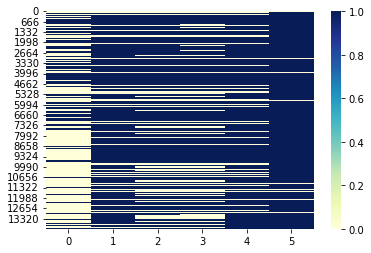

[[0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 1]
 [0 1 0 0 1 1]
 [0 1 1 0 1 1]
 [0 1 1 1 1 1]
 [1 1 1 1 1 1]]


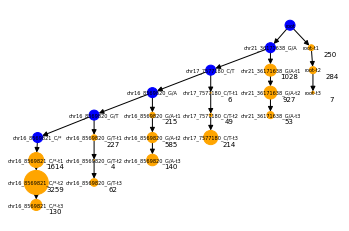

624283.7376009821


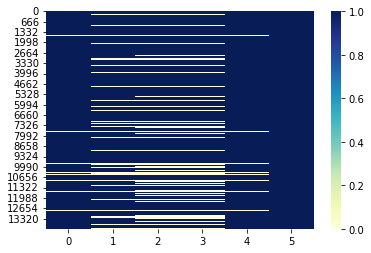

13965
[[0 0 0 0 0 1]
 [1 1 1 1 1 1]
 [0 0 0 0 1 1]
 [1 0 0 0 1 1]
 [1 1 0 0 1 1]]


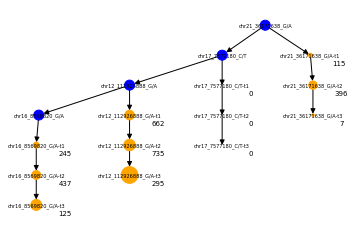

1466828.4175475836


In [837]:
analyze_SPhyR_results('AML-66', mutations66[0], mutations66[1], len(mutations66[0]), 3, size66, 13965)
analyze_COMPASS_results('AML-66', mutations66[0], mutations66[1], len(mutations66[0]), 3, size66, 13965)


## AML-97

19332


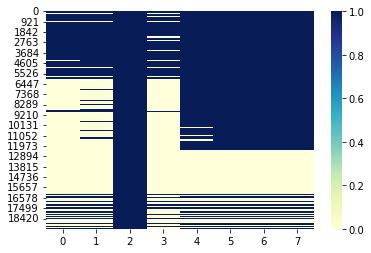

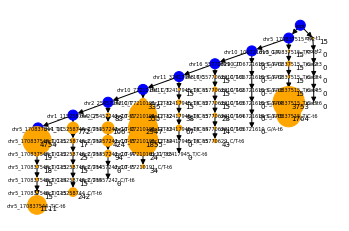

1532847.8656756915
19332


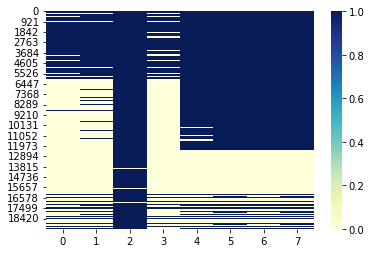

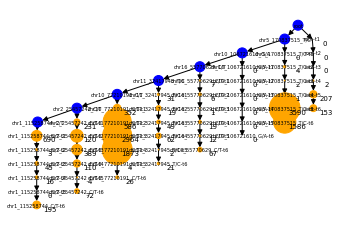

1511845.363381245


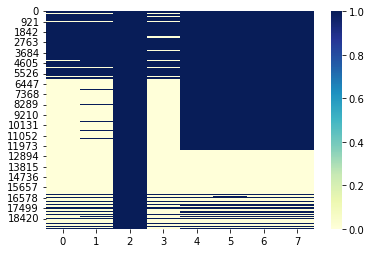

19332


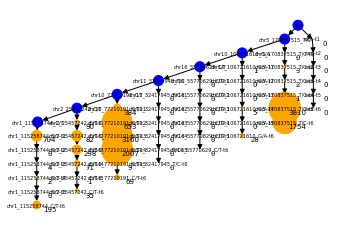

1521304.9351967887


In [812]:
analyze_ML_LSR_results('AML-97', mutations97[0], mutations97[1], len(mutations97[0]), 6, size, 19332)
analyze_SPhyR_results('AML-97', mutations97[0], mutations97[1], len(mutations97[0]), 6, size, 19332)
analyze_COMPASS_results('AML-97', mutations97[0], mutations97[1], len(mutations97[0]), 6, size, 19332)

[8347, 3168, 4203, 5421, 4618]


/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


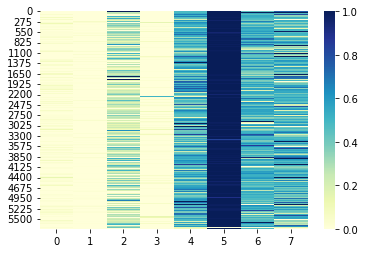

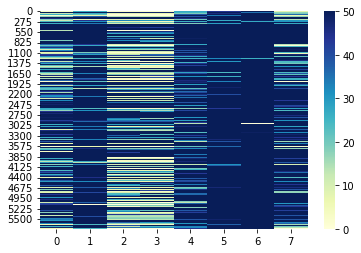

In [827]:
analyze_vafs97('AML-97', mutations97[0], size)

## AML-63

OUR METHOD
25757


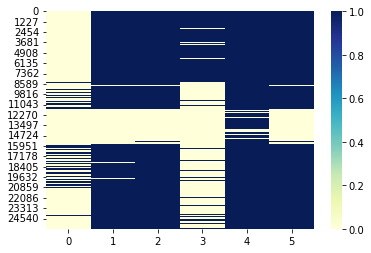

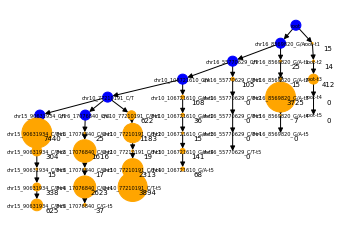

1062745.8876229061
COMPASS


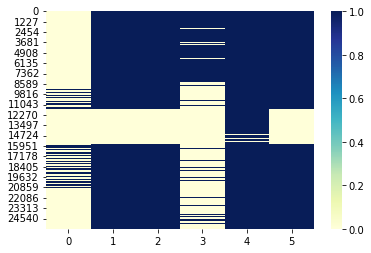

25757


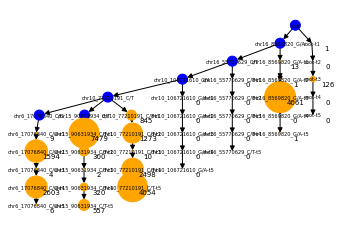

1045518.8845886864
SPhyR
25757


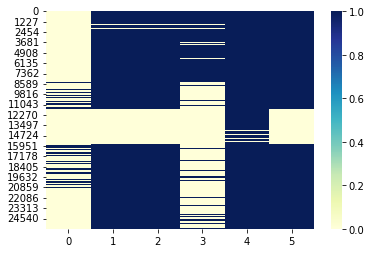

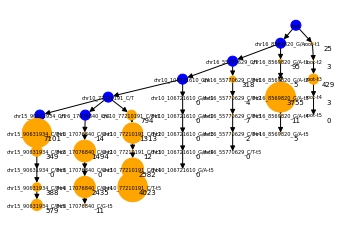

1021512.8727491172


In [822]:
print('OUR METHOD')
analyze_ML_LSR_results('AML-63', mutations[0], mutations[1], len(mutations[0]), 5, size, 25757)
print('COMPASS')
analyze_COMPASS_results('AML-63', mutations[0], mutations[1], len(mutations[0]), 5, size, 25757)
print('SPhyR')
analyze_SPhyR_results('AML-63', mutations[0], mutations[1], len(mutations[0]), 5, size, 25757)

[8347, 3168, 4203, 5421, 4618]
Index(['Unnamed: 0', 'chr6:17076840:C/G_1', 'chr10:77210191:C/T_1',
       'chr10:106721610:G/A_1', 'chr15:90631934:C/T_1', 'chr16:8569820:G/A_1',
       'chr16:55770629:C/T_1'],
      dtype='object')


/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


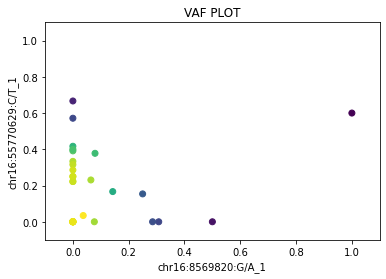

/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Index(['Unnamed: 0', 'chr6:17076840:C/G_1', 'chr10:77210191:C/T_1',
       'chr10:106721610:G/A_1', 'chr15:90631934:C/T_1', 'chr16:8569820:G/A_1',
       'chr16:55770629:C/T_1'],
      dtype='object')


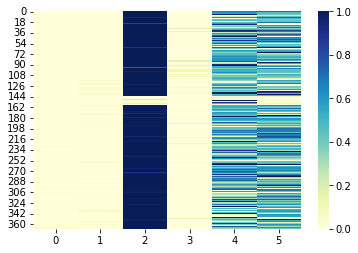

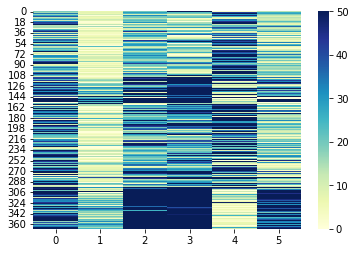

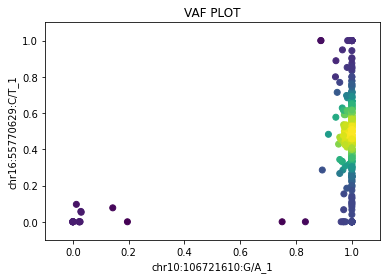

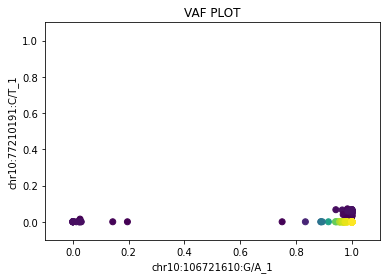

/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


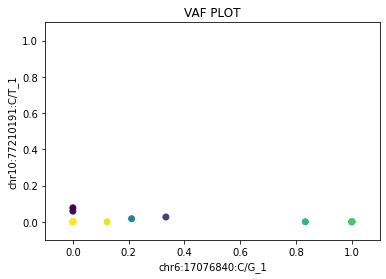

/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


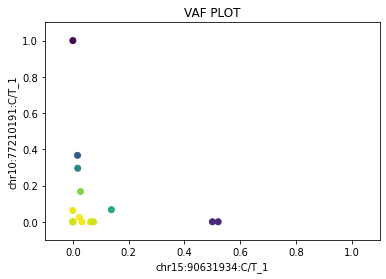

In [823]:
# Add scatterplot version of this visualization
analyze_vafs('AML-63', mutations[0], size)

# Visualize Heatmaps

In [263]:
def visualize_heatmaps(patient_name, patient_mutations, patient_annotations, ntimepoints):
    #fig, axes = plt.subplots(1, ntimepoints, figsize=(50,10))  # Adjust figsize as needed
    # f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.allvariants.genotype_modified.txt"
    valid_annots = []
    for sample in list(range(1,ntimepoints + 1)):
        ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/panel1/{patient_name}-00{sample}.loom')
        if sample == 1 and patient_name == 'AML-63':
            converted_mutations = ['chr' + ':'.join(i.split(':')[1:]) for i in ds.ra.id]
            result = [i for i in range(len(ds.ra.id)) if any(substring in converted_mutations[i] for substring in patient_mutations)]
            mut_names = [converted_mutations[i] for i in result]
        else:
            result = [i for i in range(len(ds.ra.id)) if any(substring in ds.ra.id[i] for substring in patient_mutations)]
            mut_names = [ds.ra.id[i] for i in result]
        mut_annotates = []
        for n in mut_names:
            for m in patient_mutations:
                if m in n:
                    mut_annotates.append(patient_annotations[m])
                    if patient_annotations[m] not in valid_annots:
                        valid_annots.append(patient_annotations[m])

        if sample == 1 and patient_name == 'AML-63':
            print([converted_mutations[i] for i in result])


        vafs = ds['AD'][result,:]/ds['DP'][result,:]
        print(vafs.shape)
        np.nan_to_num(vafs, copy=False,nan=0)
        
        if vafs.shape[0] < len(patient_mutations):
            for i in range(len(valid_annots)):
                if valid_annots[i] not in mut_annotates:
                    vafs = np.insert(vafs, i, -1, axis=0)
        
        #row_indices = np.where(np.sum((vafs >= 0.5), axis=1) >= 0.9*ds.shape[1])[0]

        vafs = pd.DataFrame(vafs)
        vafs.index = [ds.ra.id[i] for i in result]#patient_mutations #valid_annots
        vafs.sort_index(inplace=True)
        #sns.heatmap(RUNX1_vafs, cmap = sns.color_palette("rocket_r", as_cmap=True))
        #plt.show()
        cmap = sns.color_palette("rocket_r", as_cmap=True)
        cmap.set_under(color='yellow')
        c = sns.clustermap(vafs,  vmin=0, vmax=1,cmap = cmap,figsize=(50,10))
        c.ax_heatmap.set_title(f'Heatmap for {patient_name} Mutations for Sample {sample}')
    
    plt.show()
    return vafs

In [370]:
def visualize_character_matrix(patient_name, patient_mutations, patient_annotations, ntimepoints):
    #fig, axes = plt.subplots(1, ntimepoints, figsize=(50,10))  # Adjust figsize as needed
    valid_annots = []
    for sample in list(range(1,ntimepoints + 1)):
        vafs = pd.read_csv(f"/n/fs/ragr-data/users/aj7381/{patient_name}-00{sample}.allvariants.genotype_modified.txt", sep='\t', index_col=0)
        vafs.replace(3.0, -1, inplace=True)
        
        if sample == 1 and patient_name == 'AML-63':
            converted_mutations = ['chr' + ':'.join(i.split(':')[1:]) for i in vafs.index]
            result = [i for i in range(len(vafs.index)) if any(substring in converted_mutations[i] for substring in patient_mutations)]
            mut_names = [converted_mutations[i] for i in result]
        else:
            result = [i for i in range(len(vafs.index)) if any(substring in vafs.index[i] for substring in patient_mutations)]
            mut_names = [vafs.index[i] for i in result]
        mut_annotates = []
        for n in mut_names:
            for m in patient_mutations:
                if m in n:
                    mut_annotates.append(patient_annotations[m])
                    if patient_annotations[m] not in valid_annots:
                        valid_annots.append(patient_annotations[m])

        if sample == 1 and patient_name == 'AML-63':
            print([converted_mutations[i] for i in result])


        vafs = vafs.iloc[result]
        np.nan_to_num(vafs, copy=False,nan=0)
        
        if vafs.shape[0] < len(patient_mutations):
            for i in range(len(valid_annots)):
                if valid_annots[i] not in mut_annotates:
                    vafs = np.insert(vafs, i, -1, axis=0)
        
        #row_indices = np.where(np.sum((vafs >= 0.5), axis=1) >= 0.9*ds.shape[1])[0]
       
        #sns.heatmap(RUNX1_vafs, cmap = sns.color_palette("rocket_r", as_cmap=True))
        #plt.show()
        cmap = sns.color_palette("rocket_r", as_cmap=True)
        cmap.set_under(color='yellow')
        c = sns.clustermap(vafs,  vmin=-1, vmax=1,cmap = cmap,figsize=(50,10))
        c.ax_heatmap.set_title(f'Heatmap for {patient_name} Mutations for Sample {sample}')
    
    plt.show()
    return vafs

['chr6:17076840:C/G', 'chr10:77210191:C/T', 'chr10:106721610:G/A', 'chr15:90631934:C/T', 'chr16:8569820:G/A', 'chr16:55770629:C/T']
(6, 8347)


/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


(6, 3168)
(6, 4203)
(6, 5421)
(6, 4618)


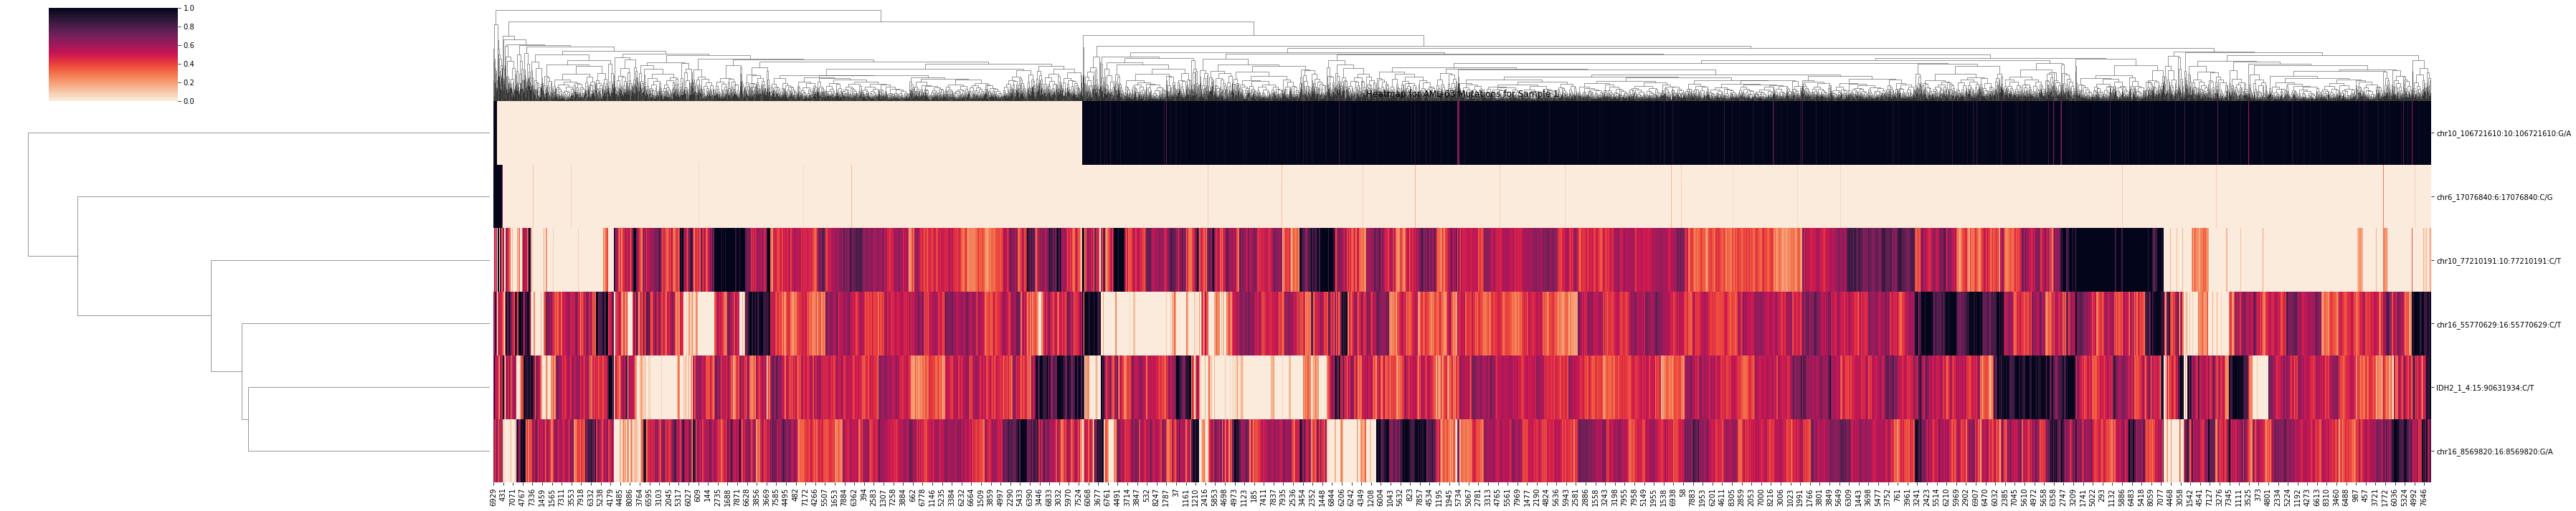

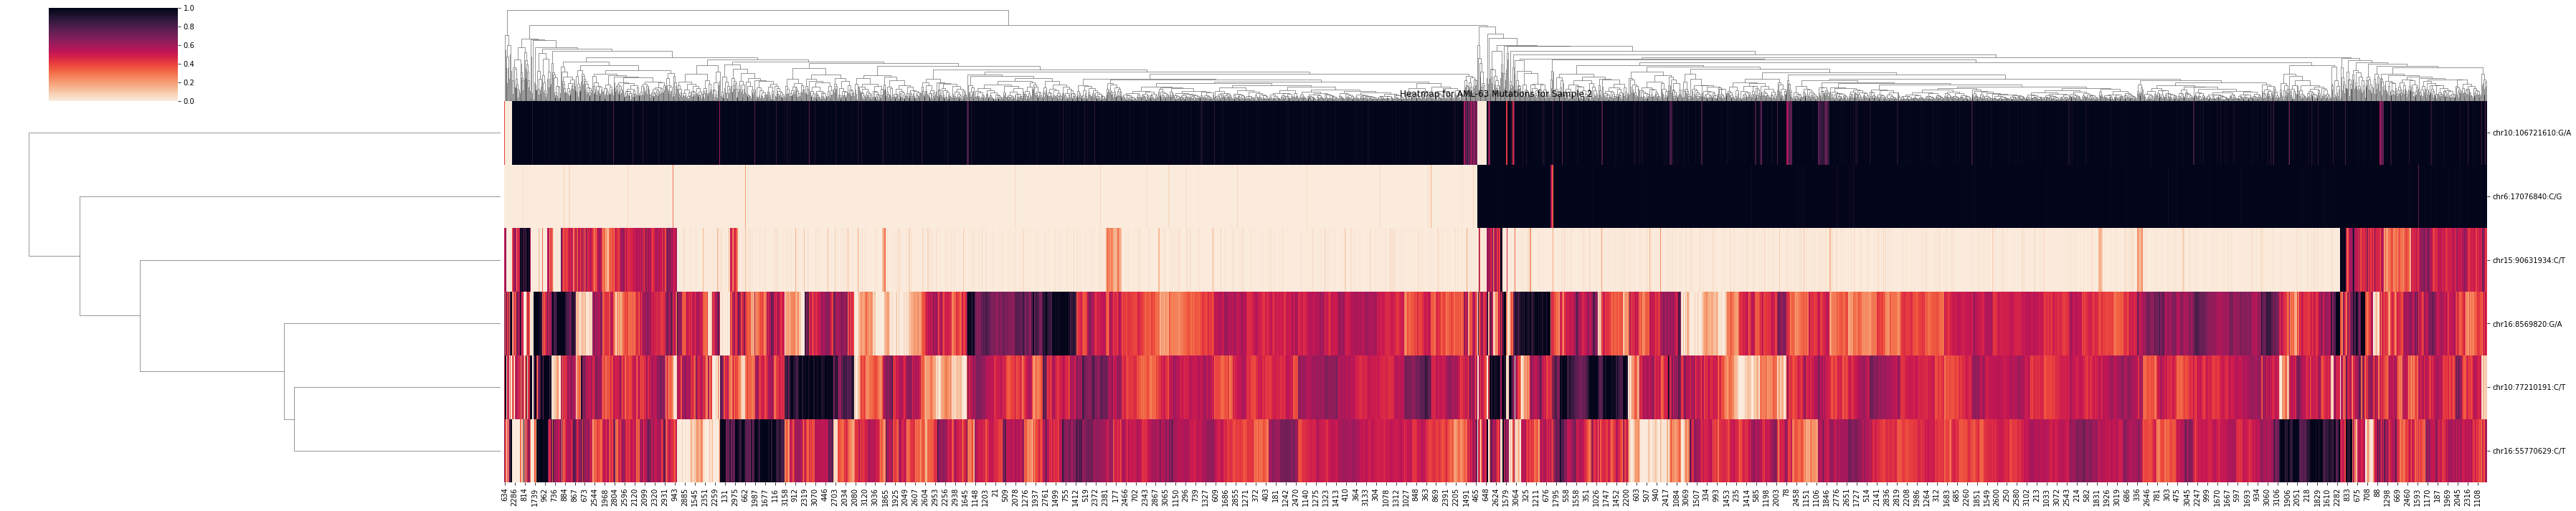

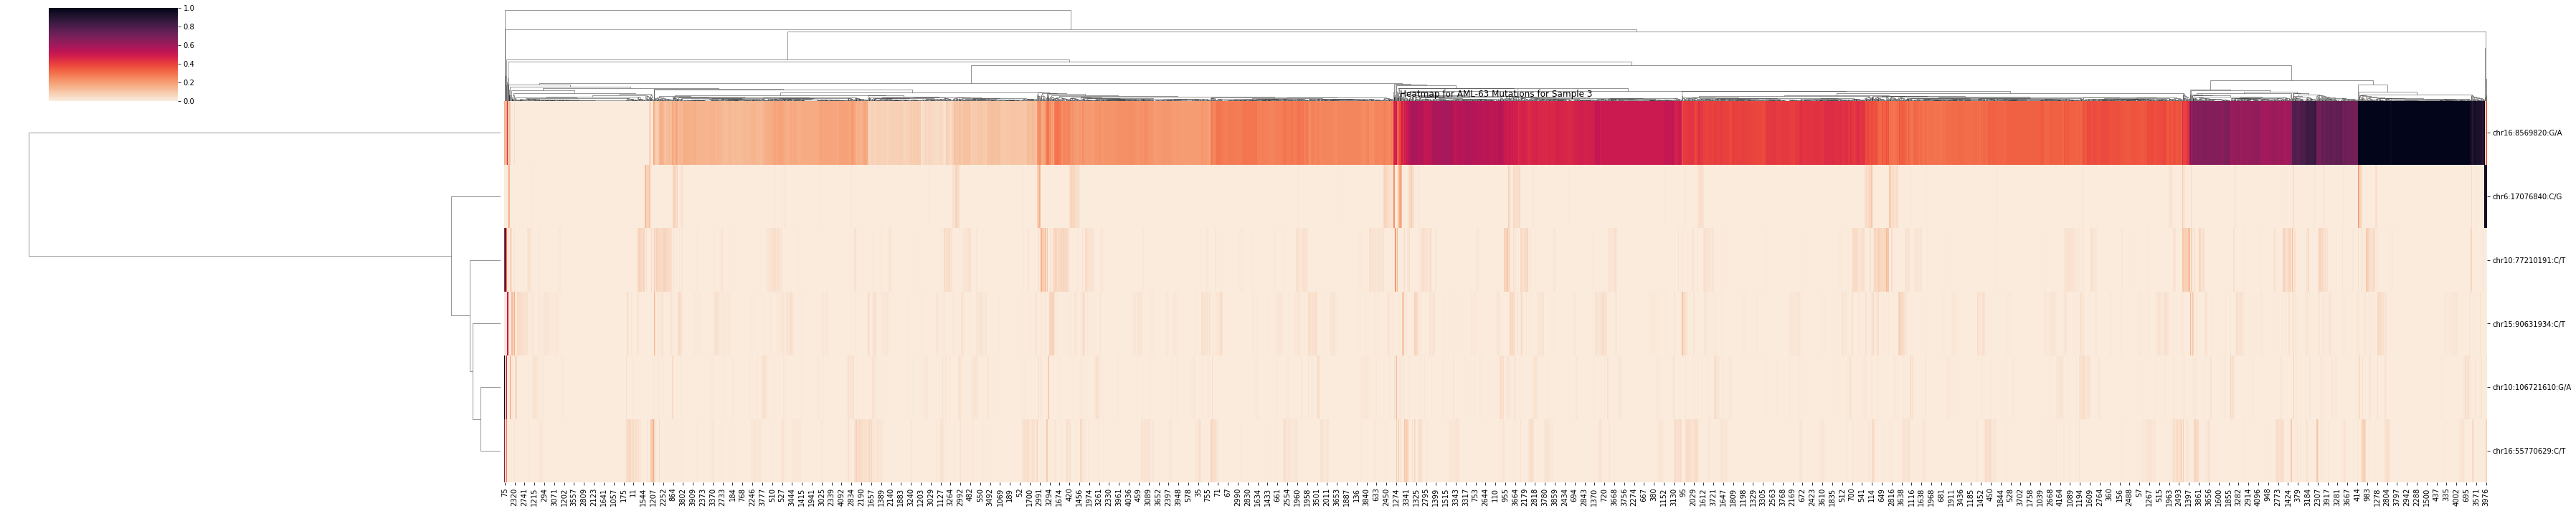

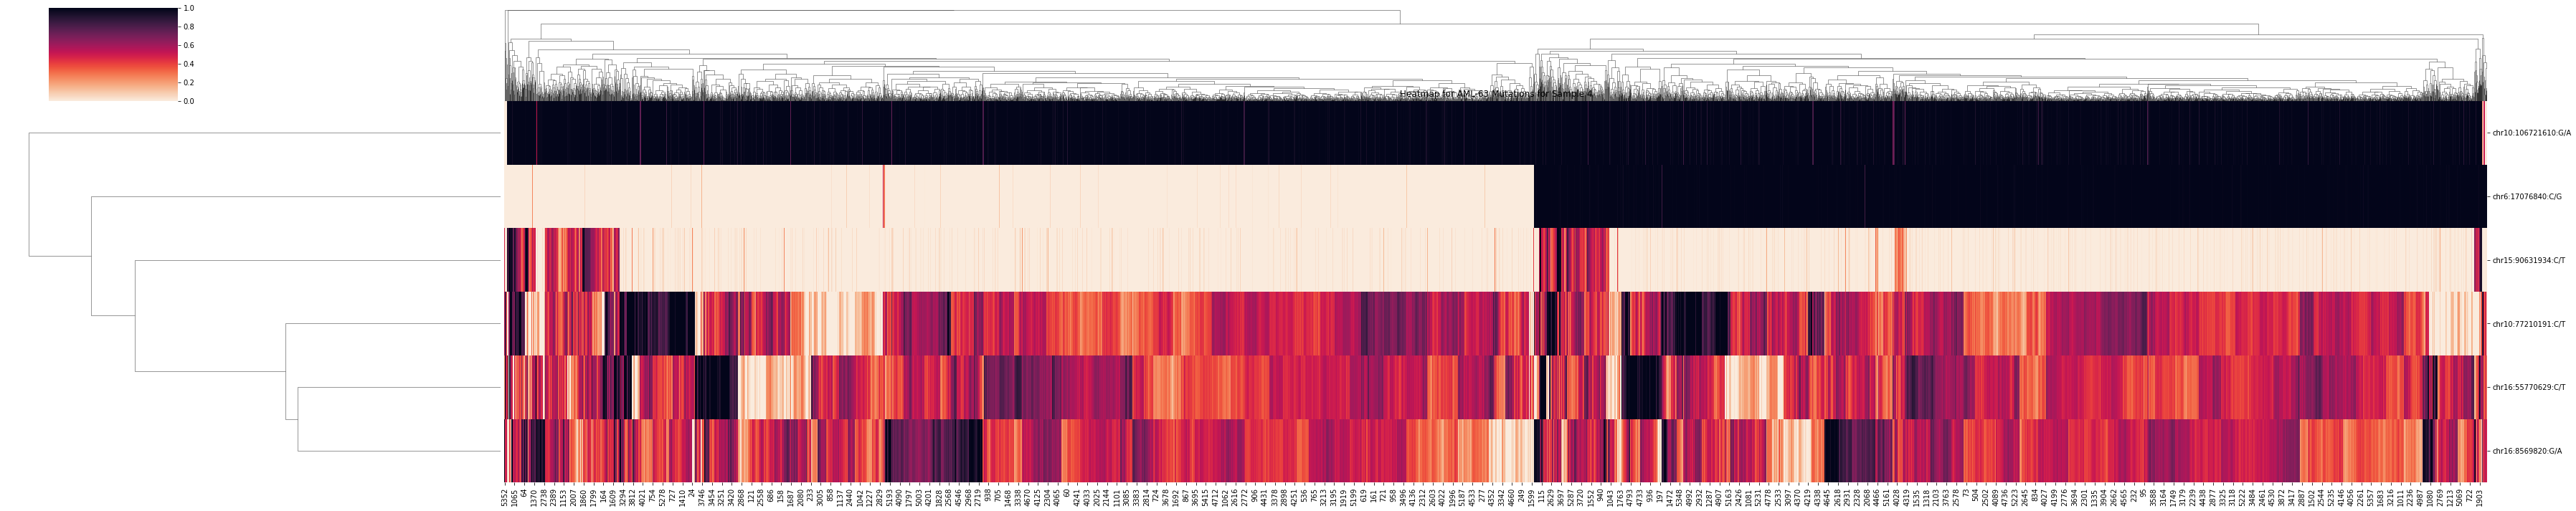

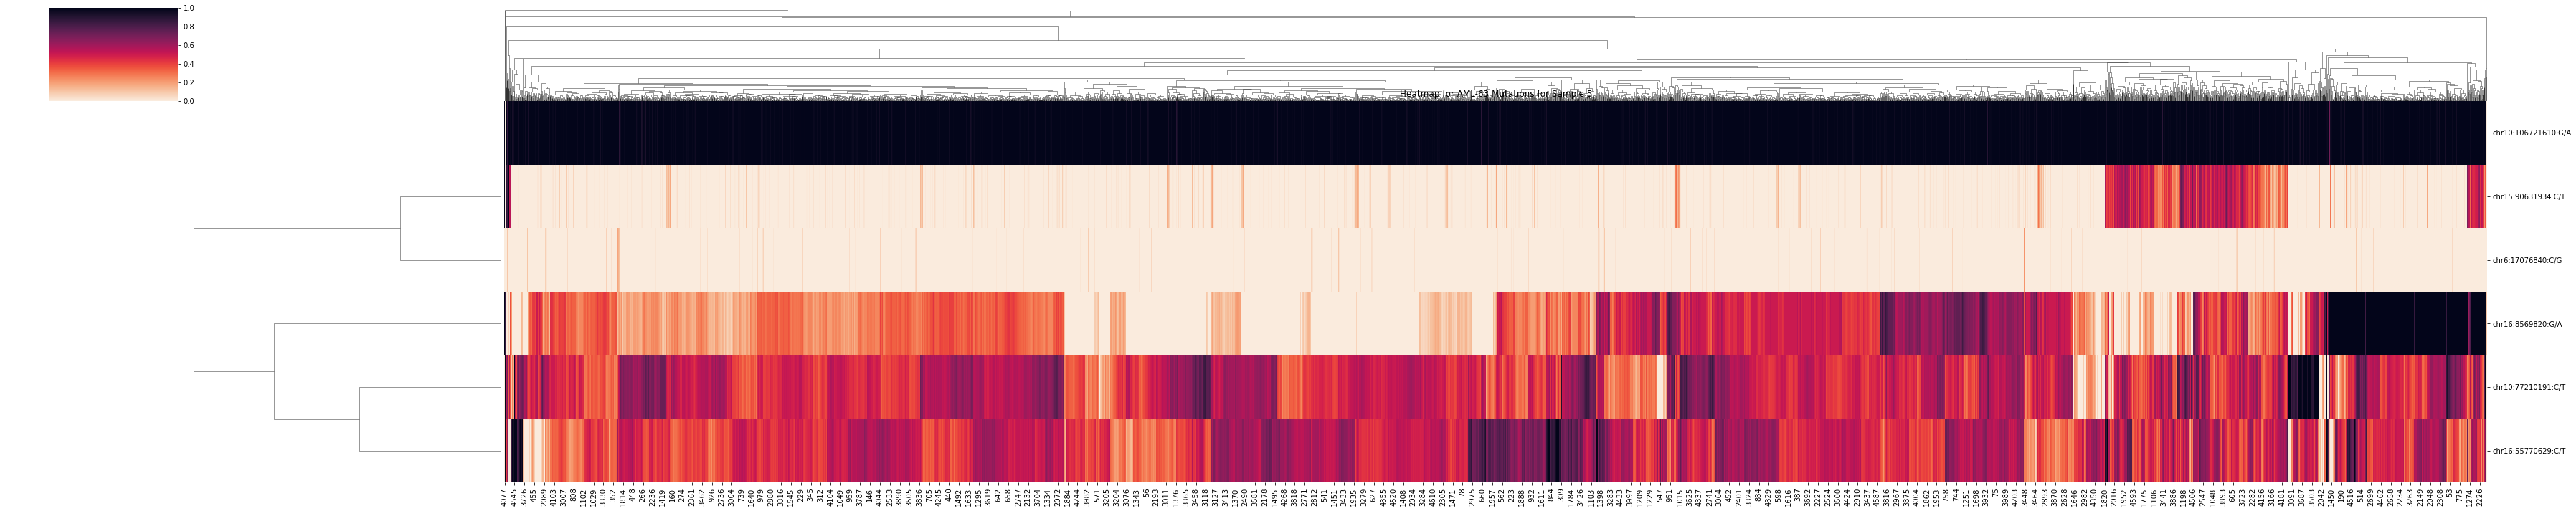

,0,1,2,3,4,5,6,7,8,9,...,4608,4609,4610,4611,4612,4613,4614,4615,4616,4617
chr10:106721610:G/A,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.980952,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.974026,1.000000,0.981982,0.986111,0.933333
chr10:77210191:C/T,0.000000,0.529412,0.617647,0.441176,0.640000,0.433333,0.353846,0.272727,0.444444,0.290909,...,0.526316,0.539604,0.511628,0.454545,0.530612,0.437500,0.260870,0.937500,0.666667,0.401786
chr15:90631934:C/T,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chr16:55770629:C/T,0.431373,0.333333,0.306122,0.439024,0.884615,0.674419,0.493827,0.458333,0.362832,0.651163,...,0.488372,0.733333,0.523256,0.478261,0.400000,0.125000,0.410256,0.500000,0.536765,0.375000
chr16:8569820:G/A,0.666667,0.000000,0.222222,0.500000,0.000000,0.333333,0.000000,0.000000,0.071429,0.384615,...,0.500000,0.200000,0.128205,0.428571,0.250000,0.000000,0.000000,0.190476,0.162162,0.250000
chr6:17076840:C/G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [378]:
#visualize_heatmaps('AML-97', mutations[0], mutations[1], 6)
visualize_heatmaps('AML-63', mutations[0], mutations[1], 5)


['chr6:17076840:C/G', 'chr10:77210191:C/T', 'chr10:106721610:G/A', 'chr15:90631934:C/T', 'chr16:8569820:G/A', 'chr16:55770629:C/T']


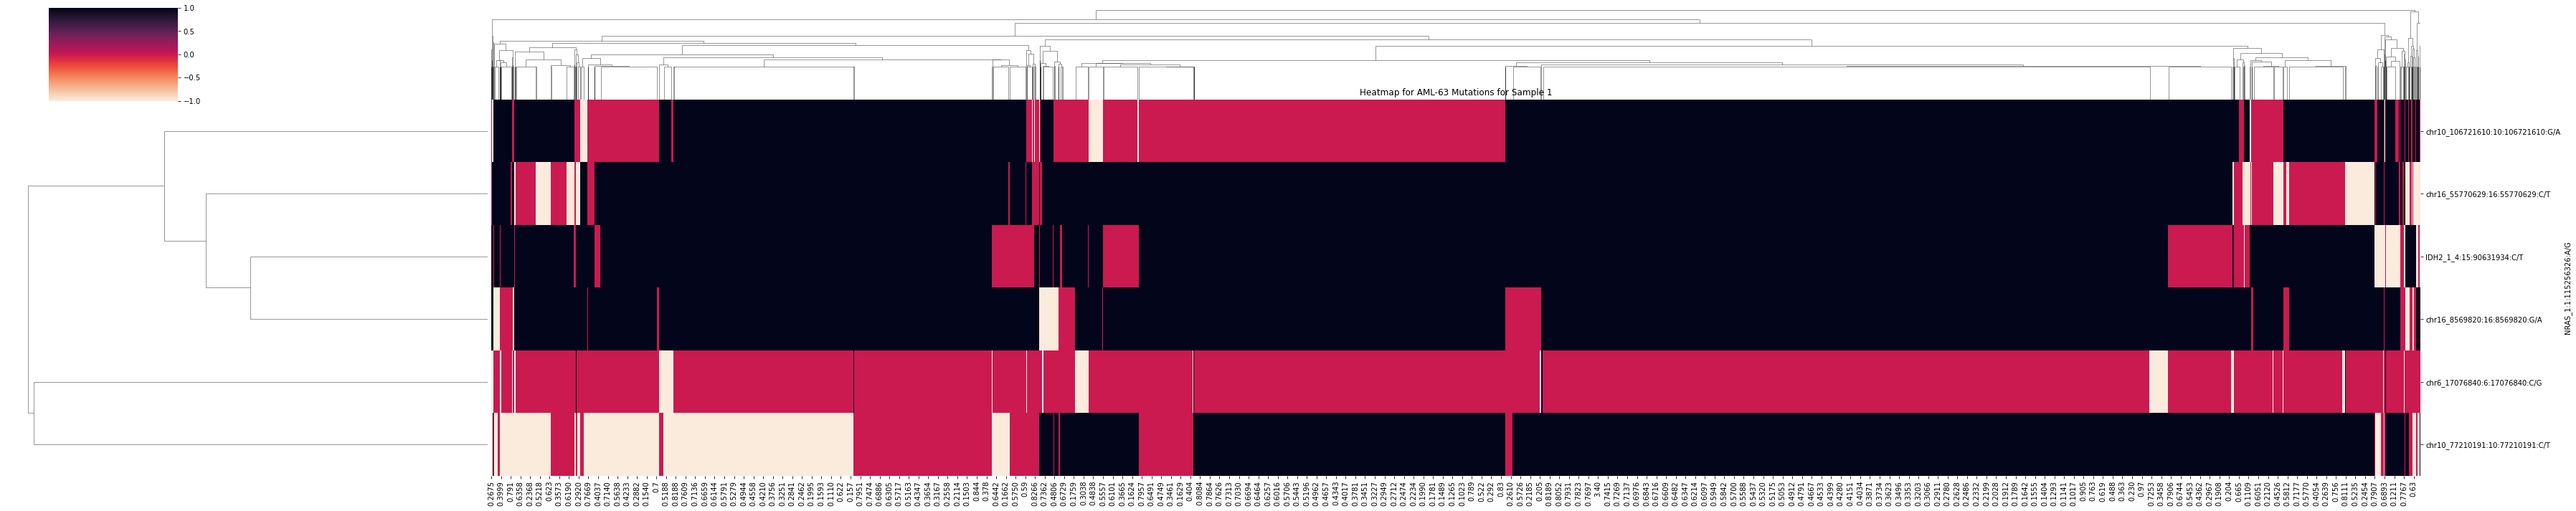

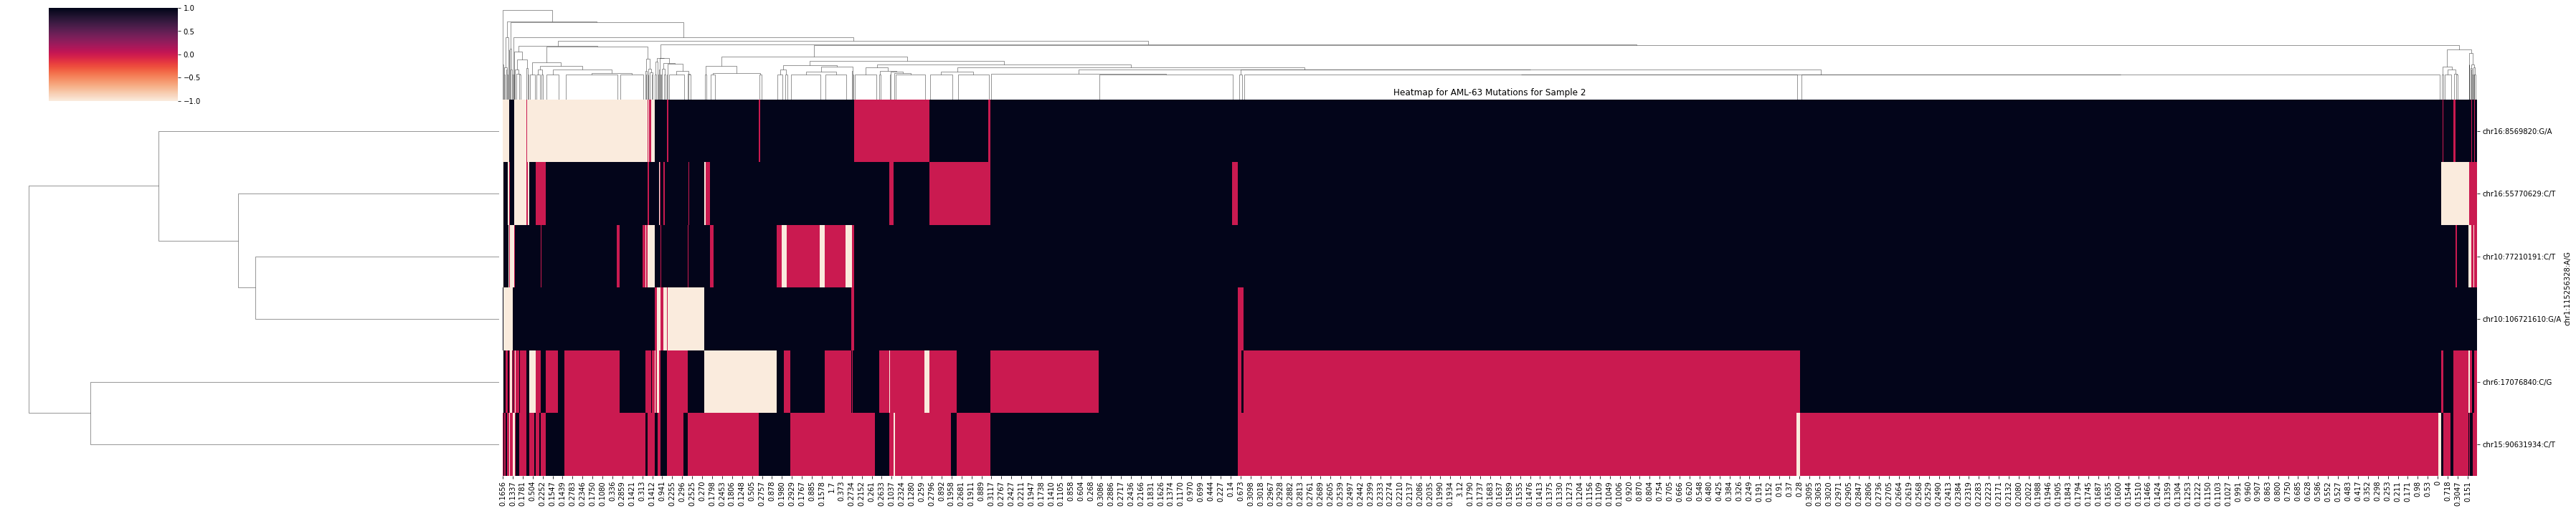

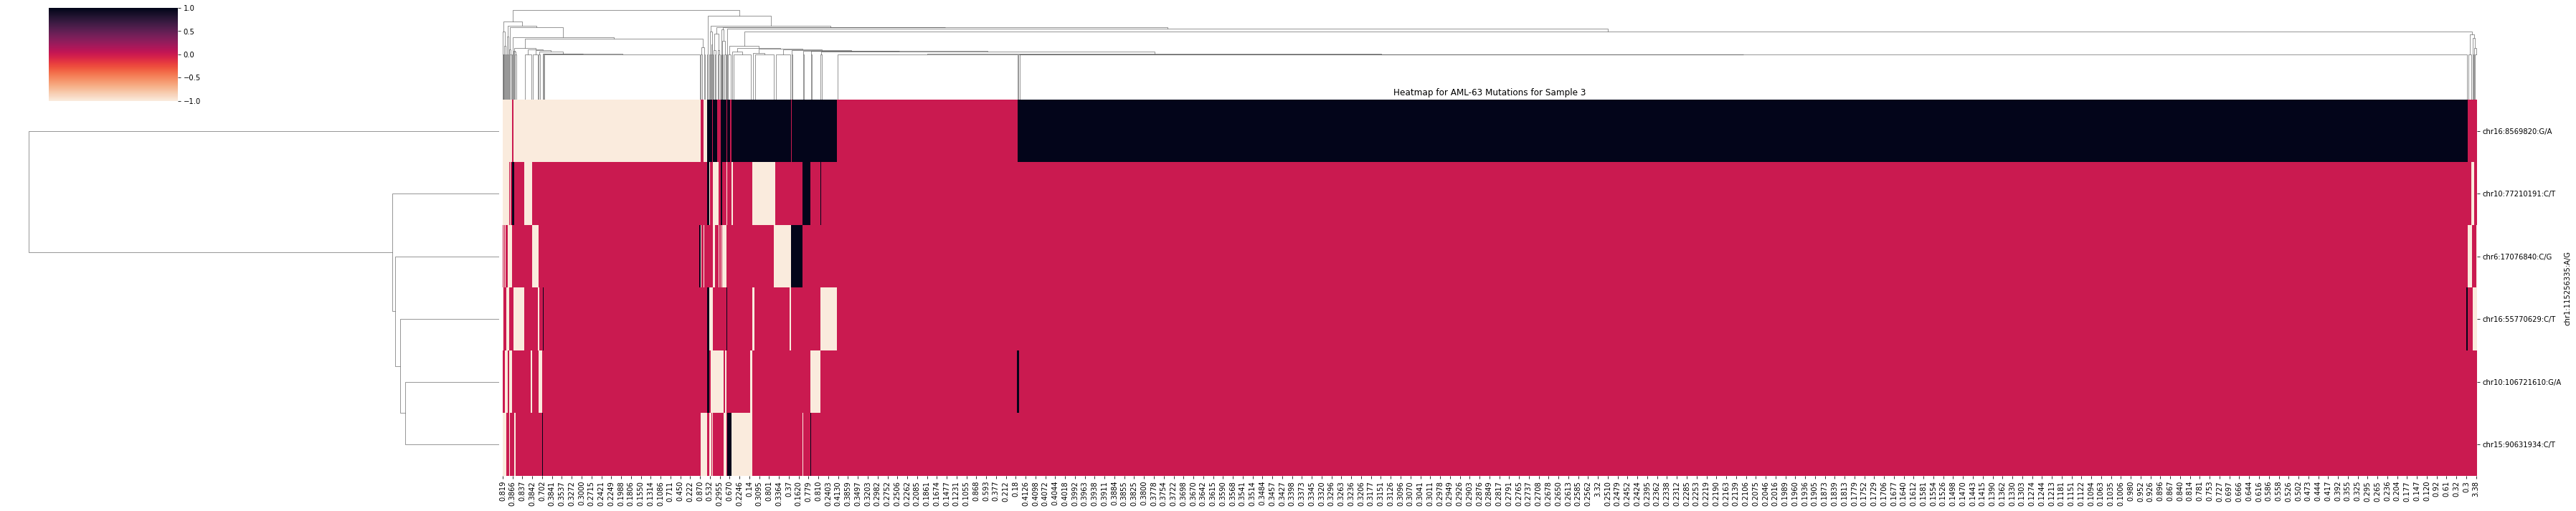

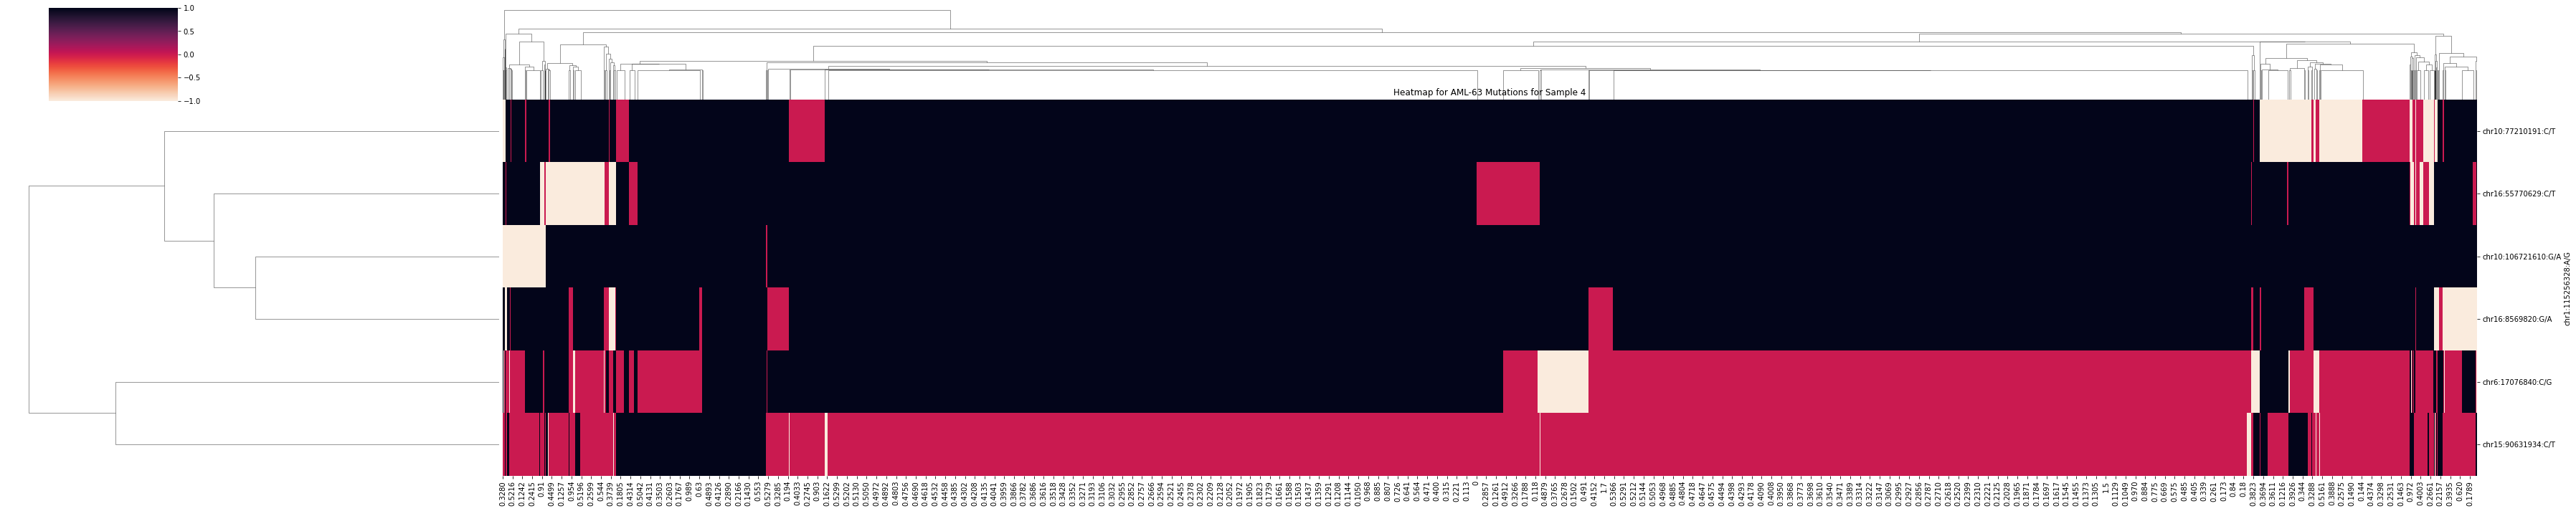

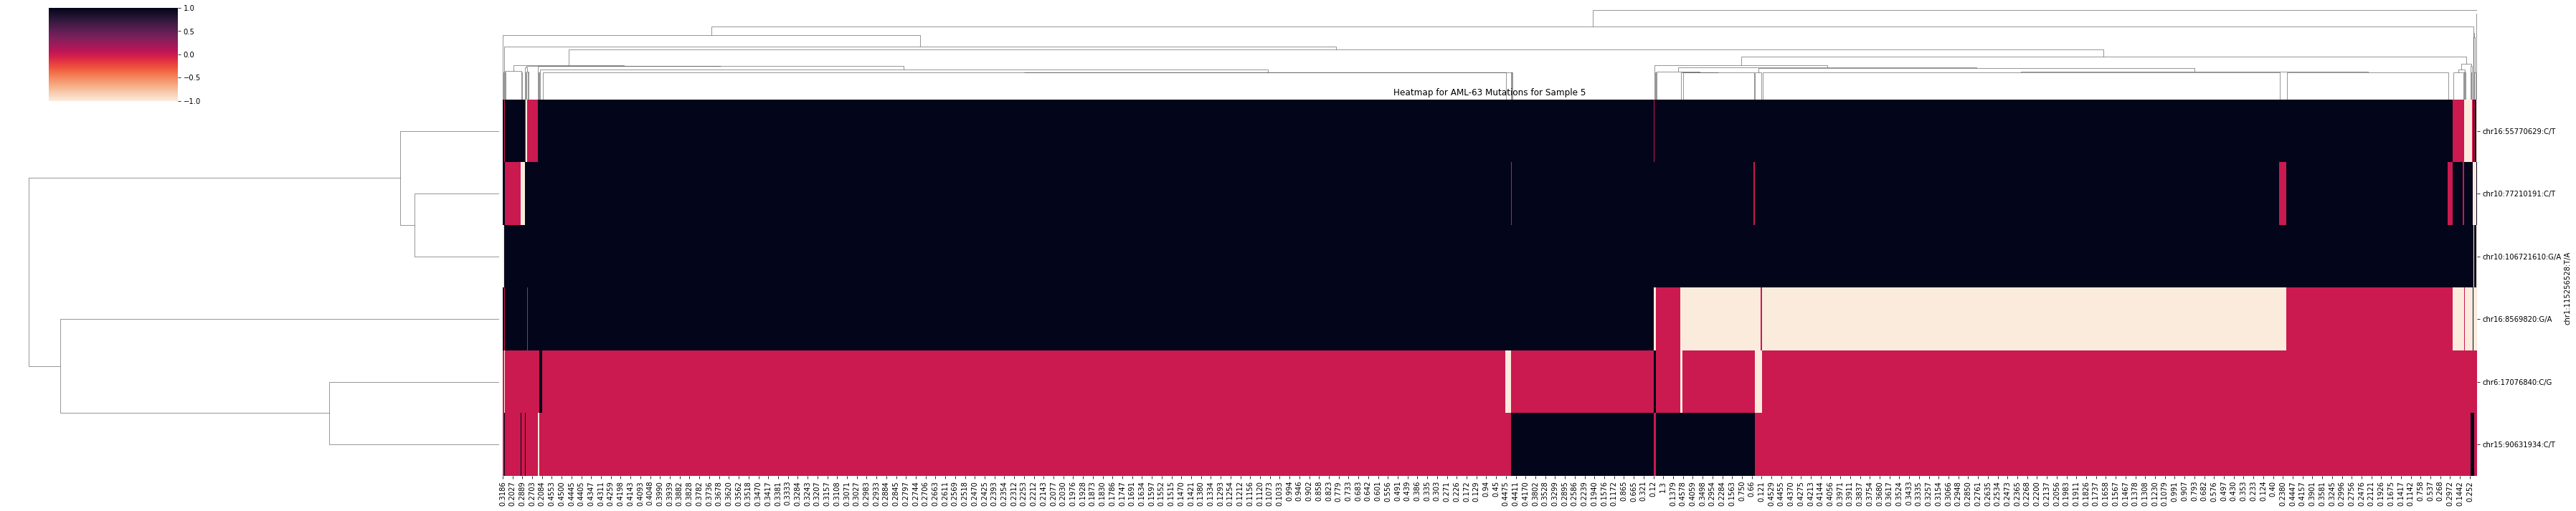

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.4596,0.4597,0.4598,0.4599,0.4600,0.4601,0.4602,0.4603,0.4604,0.4605
chr1:115256528:T/A,,,,,,,,,,,,,,,,,,,,,
chr6:17076840:C/G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr10:77210191:C/T,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
chr10:106721610:G/A,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
chr15:90631934:C/T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr16:8569820:G/A,-1,-1,1,-1,-1,-1,-1,-1,0,1,...,-1,1,1,1,1,0,-1,1,1,1
chr16:55770629:C/T,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [380]:
import sys
sys.setrecursionlimit(100000)
visualize_character_matrix('AML-63', mutations[0], mutations[1], 5)

# Miscellaneous Code

NPM1 0    34.0
dtype: float64
FLT3 0    96.0
dtype: float64


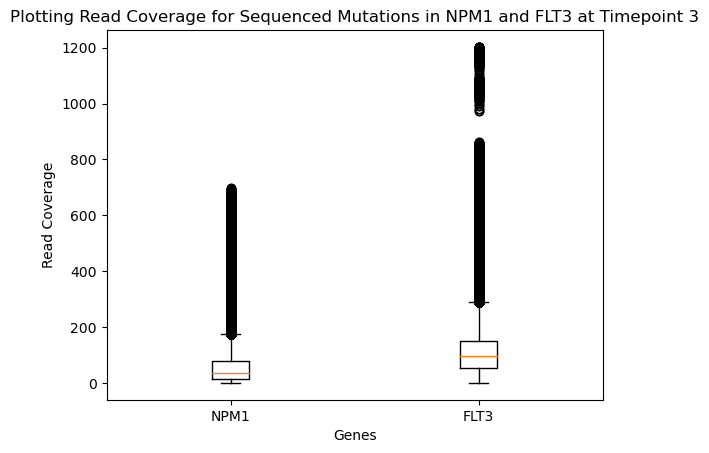

FLT3 0    40.0
dtype: float64


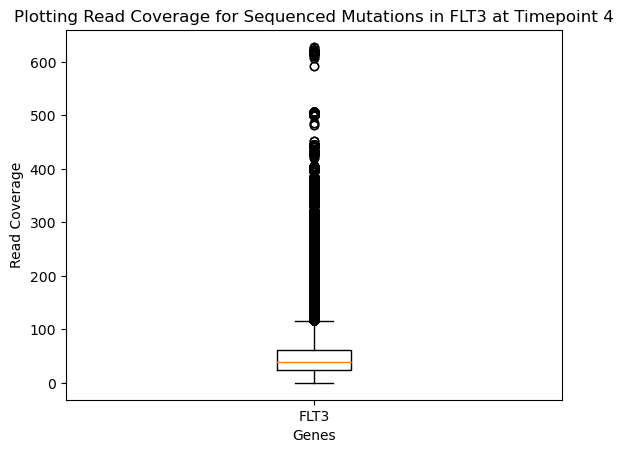

FLT3 0    58.0
dtype: float64
KIT 0    58.0
dtype: float64


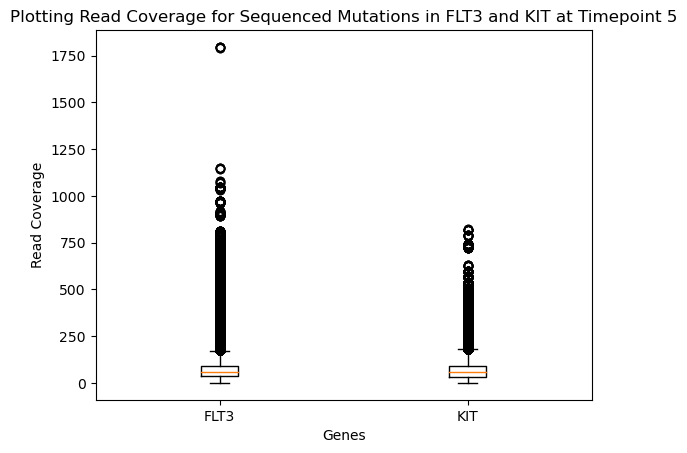

In [297]:


ds = loompy.connect(f'/n/fs/ragr-data/users/aj7381/panel1/AML-63-00{3}.loom')
genes = []
for i in range(len(ds.ra.id)):
    if len(str(ds.ra.amplicon[i]).split('_')) > 1:
        genes.append(str(ds.ra.amplicon[i]).split('_')[0])
    else:
        genes.append(str(ds.ra.amplicon[i]))

genes_of_interest = ["NPM1","FLT3"]
dp_layer = []
for idx, gene in enumerate(genes_of_interest):
    special_gene_idxs = [i for i in range(len(ds.ra.id)) if genes[i] in [genes_of_interest[idx]]]
    dp_layer.append( ds.layer["DP"][special_gene_idxs,:].flatten())


plt.boxplot(dp_layer)
for i, p in enumerate(dp_layer):
    print(genes_of_interest[i], pd.DataFrame(p).median())
plt.xticks(list(range(1, len(genes_of_interest) + 1)), genes_of_interest)
plt.title('Plotting Read Coverage for Sequenced Mutations in NPM1 and FLT3 at Timepoint 3')
plt.xlabel('Genes')
plt.ylabel('Read Coverage')
plt.show()




ds = loompy.connect(f'/n/fs/ragr-data/users/aj7381/panel1/AML-63-00{4}.loom')
genes = []
for i in range(len(ds.ra.id)):
    if len(str(ds.ra.amplicon[i]).split('_')) > 1:
        genes.append(str(ds.ra.amplicon[i]).split('_')[0])
    else:
        genes.append(str(ds.ra.amplicon[i]))

genes_of_interest = ["FLT3"]
dp_layer = []
for idx, gene in enumerate(genes_of_interest):
    special_gene_idxs = [i for i in range(len(ds.ra.id)) if genes[i] in [genes_of_interest[idx]]]
    dp_layer.append( ds.layer["DP"][special_gene_idxs,:].flatten())


plt.boxplot(dp_layer)
for i, p in enumerate(dp_layer):
    print(genes_of_interest[i], pd.DataFrame(p).median())
plt.xticks(list(range(1, len(genes_of_interest) + 1)), genes_of_interest)
plt.title('Plotting Read Coverage for Sequenced Mutations in FLT3 at Timepoint 4')
plt.xlabel('Genes')
plt.ylabel('Read Coverage')
plt.show()

ds = loompy.connect(f'/n/fs/ragr-data/users/aj7381/panel1/AML-63-00{5}.loom')
genes = []
for i in range(len(ds.ra.id)):
    if len(str(ds.ra.amplicon[i]).split('_')) > 1:
        genes.append(str(ds.ra.amplicon[i]).split('_')[0])
    else:
        genes.append(str(ds.ra.amplicon[i]))

genes_of_interest = ["FLT3", "KIT"]
dp_layer = []
for idx, gene in enumerate(genes_of_interest):
    special_gene_idxs = [i for i in range(len(ds.ra.id)) if genes[i] in [genes_of_interest[idx]]]
    dp_layer.append( ds.layer["DP"][special_gene_idxs,:].flatten())


plt.boxplot(dp_layer)
for i, p in enumerate(dp_layer):
    print(genes_of_interest[i], pd.DataFrame(p).median())
plt.xticks(list(range(1, len(genes_of_interest) + 1)), genes_of_interest)
plt.title('Plotting Read Coverage for Sequenced Mutations in FLT3 and KIT at Timepoint 5')
plt.xlabel('Genes')
plt.ylabel('Read Coverage')
plt.show()



/tmp/ipykernel_3343483/488772424.py:26: RuntimeWarning: invalid value encountered in divide
  vafs = ds['AD'][result,:]/ds['DP'][result,:]
/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/mosaic/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


(3, 6013)


TypeError: heatmap() got multiple values for keyword argument 'ax'

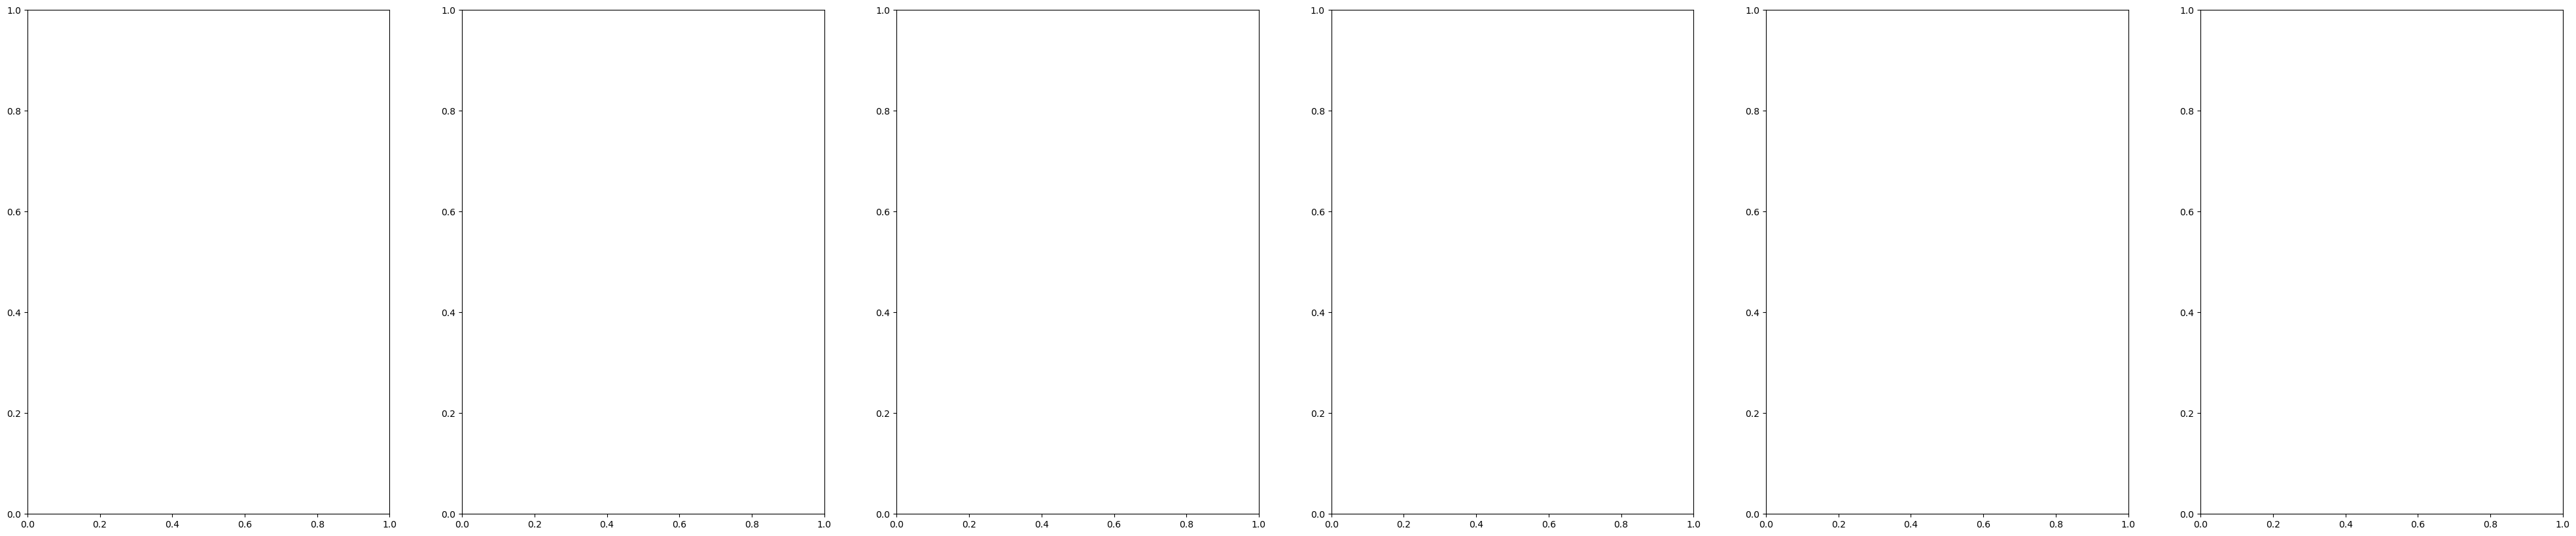

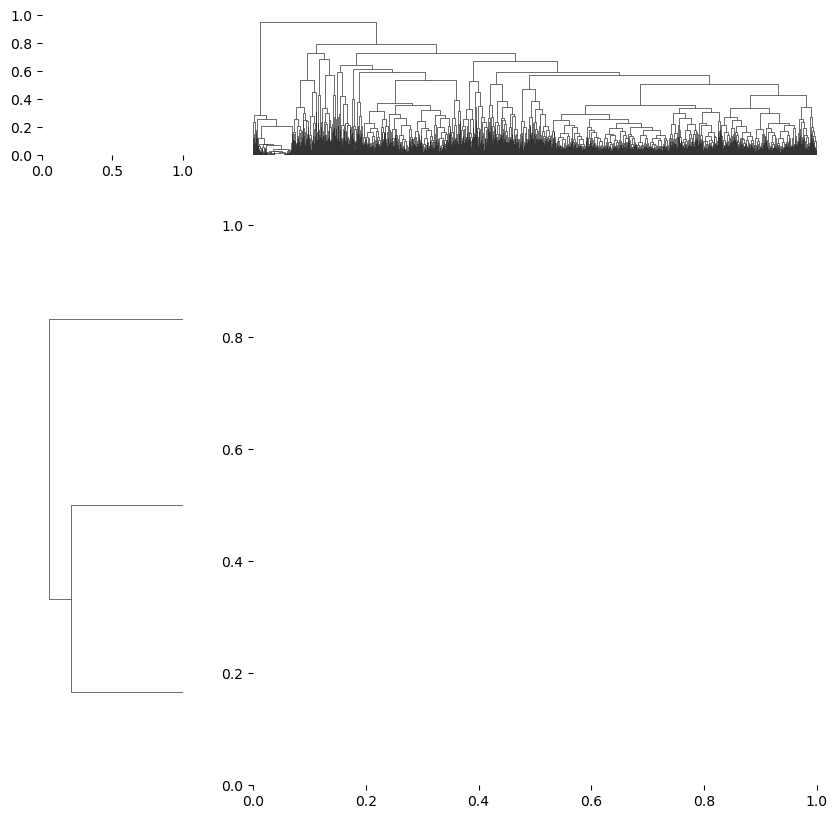

In [805]:
#aml63_mutations, aml63_annotations = select_mutation('AML-97', 6)
mutations_of_interest = ['chr5:170837543:C/CTCTG', 'chr1:115258744:C/T', 'chr2:25457242:C/T']
annotations = {'chr5:170837543:C/CTCTG': 'NPM1 p.L287fs', 'chr1:115258744:C/T': 'NRAS p.G13D', 'chr2:25457242:C/T': 'DNMT3A p.R882H'}
vafs = visualize_heatmaps('AML-97', mutations_of_interest, annotations, 6)

/tmp/ipykernel_3343483/3455223759.py:26: RuntimeWarning: invalid value encountered in divide
  vafs = ds['AD'][result,:]/ds['DP'][result,:]


(6, 6013)
(6, 742)
(6, 3482)
(6, 2089)
(6, 3820)
(6, 3186)


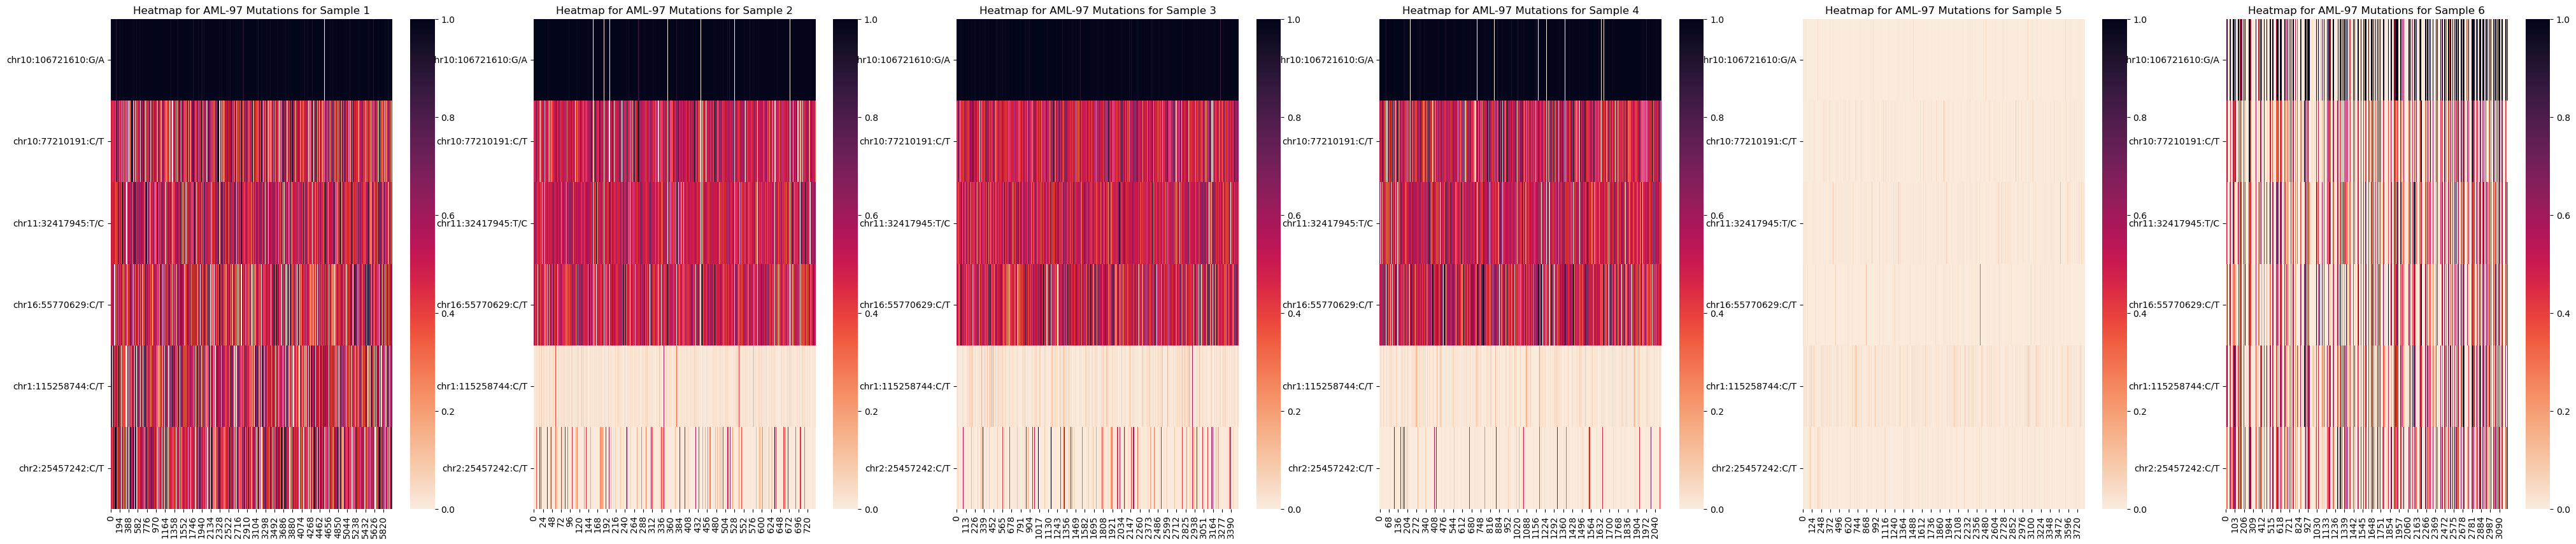

In [803]:
vafs = visualize_heatmaps('AML-97', aml63_mutations, aml63_annotations, 6)

In [791]:
# AML63 Patient Morita et al. Mutations

#aml63_mutations = ['13:28608303:X/XAGTTTCTCTTGGAA', '15:90631934:C/T', '4:55599321:A/T', '5:170837543:C/CTCTG']
#aml63_annotations = {'13:28608303:X/XAGTTTCTCTTGGAA': 'FLT3 p.S585fs', '15:90631934:C/T': 'IDH2 p.R140Q', '4:55599321:A/T': 'KIT p.D816V', '5:170837543:C/CTCTG': 'NPM1 p.L287fs'}
#preprocess_loom_files('AML-97', 6)
merged_df, size = produce_SCITE_input('AML-97', aml63_mutations, 6)

#run_SCITE('AML-63', merged_df.shape[0], merged_df.shape[1], 0.01, 0.037, 100, 5, 0.002)

In [792]:
print(merged_df)
#merged_df.astype(bool).sum(axis=1)

                       0     1     2     3     4     5     6     7     8     \
chr1:115258744:C/T_1    3.0   0.0   1.0   1.0   1.0   3.0   3.0   1.0   1.0   
chr2:25457242:C/T_1     3.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
chr10:77210191:C/T_1    1.0   1.0   1.0   1.0   1.0   3.0   1.0   1.0   1.0   
chr10:106721610:G/A_1   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
chr11:32417945:T/C_1    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
chr16:55770629:C/T_1    3.0   0.0   1.0   1.0   1.0   3.0   1.0   1.0   1.0   

                       9     ...  3176  3177  3178  3179  3180  3181  3182  \
chr1:115258744:C/T_1    2.0  ...   0.0   0.0   1.0   0.0   1.0   0.0   1.0   
chr2:25457242:C/T_1     1.0  ...   0.0   0.0   0.0   0.0   1.0   0.0   1.0   
chr10:77210191:C/T_1    1.0  ...   0.0   0.0   0.0   0.0   1.0   0.0   1.0   
chr10:106721610:G/A_1   2.0  ...   0.0   0.0   1.0   0.0   1.0   0.0   1.0   
chr11:32417945:T/C_1    1.0  ...   3.0   0.0   0.0   0.0

{'chr11_32417945_T/C': {1: 55, 2: 23, 3: 20, 4: 57, 5: 28, 6: 68}, 'chr1_115258744_C/T': {1: 5228, 2: 16, 3: 57, 4: 12, 5: 3, 6: 1207}, 'chr16_55770629_C/T': {1: 174, 2: 52, 3: 124, 4: 181, 5: 9, 6: 55}, 'chr2_25457242_C/T': {1: 1027, 2: 110, 3: 401, 4: 117, 5: 4, 6: 282}, 'chr10_77210191_C/T': {1: 584, 2: 614, 3: 3084, 4: 1904, 5: 7, 6: 89}, 'chr10_106721610_G/A': {1: 19, 2: 24, 3: 6, 4: 37, 5: 67, 6: 127}, 'root': {1: 0, 2: 0, 3: 0, 4: 0, 5: 3460, 6: 0}}


/tmp/ipykernel_3343483/327595095.py:48: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


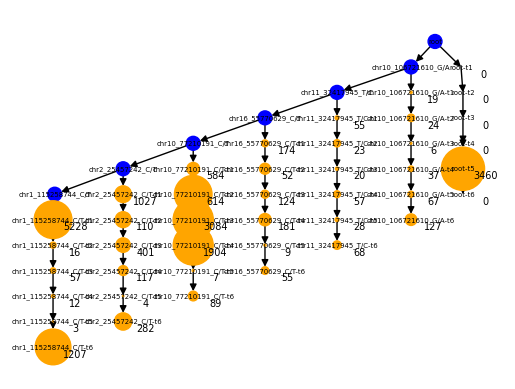

/tmp/ipykernel_3343483/550761123.py:26: RuntimeWarning: invalid value encountered in divide
  vafs = ds['AD'][result,:]/ds['DP'][result,:]


(6, 6013)
(6, 742)
(6, 3482)
(6, 2089)
(6, 3820)
(6, 3186)


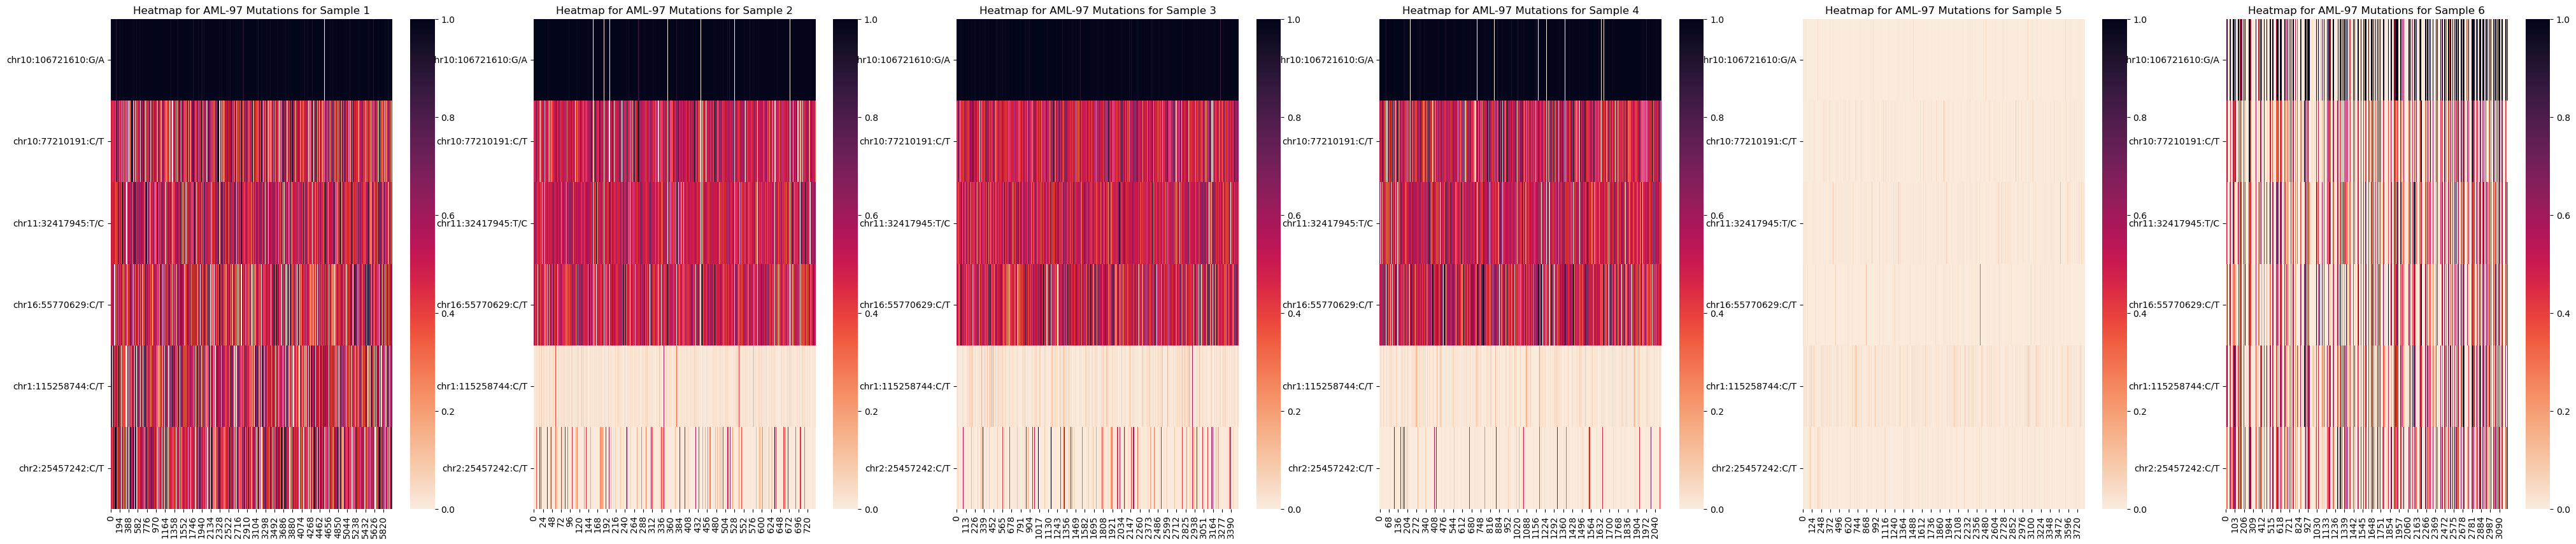

,0,1,2,3,4,5,6,7,8,9,...,3176,3177,3178,3179,3180,3181,3182,3183,3184,3185
chr10:106721610:G/A,0.166667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.645833,0.000000,0.895833,...,0.00000,0.000000,0.348837,0.000000,0.745902,0.000000,0.575000,1.000000,1.000000,0.0
chr10:77210191:C/T,0.642857,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205128,0.000000,0.714286,...,0.00000,0.045455,0.000000,0.000000,0.341463,0.043478,0.171429,0.000000,0.357143,0.0
chr11:32417945:T/C,0.210526,0.509615,0.008850,0.033333,0.000000,0.019608,0.025862,0.327485,0.025478,0.435897,...,0.00000,0.000000,0.000000,0.034884,0.324232,0.000000,0.000000,0.456897,0.627907,0.0
chr16:55770629:C/T,0.000000,0.765957,0.000000,0.000000,0.000000,0.000000,0.000000,0.555556,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.148148,0.000000,0.451613,0.666667,0.285714,0.0
chr1:115258744:C/T,0.000000,0.500000,0.018519,0.105263,0.000000,0.026316,0.000000,0.366667,0.000000,0.375000,...,0.00000,0.020000,0.259259,0.029851,0.620000,0.000000,0.725000,0.692308,0.600000,0.0
chr2:25457242:C/T,0.000000,0.616162,0.000000,0.000000,0.013423,0.000000,0.000000,0.209677,0.000000,0.500000,...,0.01626,0.020000,0.000000,0.000000,0.313253,0.000000,0.370370,1.000000,0.397059,0.0


In [793]:
visualize_heatmaps('AML-97', aml63_mutations, aml63_annotations, 6)

# Unused SCARLET Input Code

In [789]:
def build_scarlet_input(patient_name, patient_mutations, ntimepoints):
    for sample in list(range(1,ntimepoints + 1)):
        ds = lp.connect(f'/n/fs/ragr-data/users/aj7381/panel1/{patient_name}-00{sample}.loom')

        mutation_idxs = [i for i in range(len(ds.ra.id)) if any(substring in ds.ra.id[i] for substring in patient_mutations)]
        organied_parent_mutations = [ds.ra.id[i] for i in mutation_idxs]
        cols = [string + suffix for string in organied_parent_mutations for suffix in ("_v", "_t")]
        cols = ['c'] + cols
        alt_counts = ds['AD'][mutation_idxs,:].T
        total_counts = ds['DP'][mutation_idxs,:].T
        read_count_matrix = np.zeros((alt_counts.shape[0], 1+2*alt_counts.shape[1]))
        read_count_matrix[:, 1::2] = alt_counts
        read_count_matrix[:, 2::2] = total_counts
        df_readcount_matrix = pd.DataFrame(read_count_matrix, index=[f's_{sample}_c{i}' for i in range(alt_counts.shape[0])], columns=cols)
        df_readcount_matrix.index.name = 'cell_id'

        with open(f'/n/fs/ragr-data/users/aj7381/aml97_sciphi_results/inputs/{patient_name}_00{sample}.mpileup', 'w') as out:
            for mutation in organied_parent_mutations:
                vs = df_readcount_matrix[f'{mutation}_v']
                ts = df_readcount_matrix[f'{mutation}_t']

                seq_name = mutation.split(':')[0]
                pos = int(mutation.split(':')[1])
                ref_allele = mutation.split(':')[2].split('/')[0]
                entries = [seq_name, pos, ref_allele]
                for v,t in zip(vs, ts):
                    readcov = int(t)
                    readstring = '.'*int(t-v) + 'T'*int(v)                                                              
                    qualstring = '?'*int(t)                                                                          
                    entries += [readcov, readstring, qualstring] 
                out.write("\t".join(map(str, entries))+'\n')
        with open(f'/n/fs/ragr-data/users/aj7381/aml97_sciphi_results/inputs/{patient_name}_00{sample}._cell_names.csv', 'w') as out:
            for i in df_readcount_matrix.index:
                out.write('{}\tCT\n'.format(i))



In [790]:
build_scarlet_input('AML-97', aml63_mutations, 6)